# Описание проекта

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. В вашем распоряжении данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>   
  
часть блоков , где идет подбор параметров закомментирована, это экономит примерно 2 часа времени!
</div>

# Подготовка данных

 ## Откройте файлы и изучите их

In [1]:
# 
import pandas as pd
import numpy as np
#
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.naive_bayes import GaussianNB  
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.metrics import accuracy_score,classification_report, confusion_matrix,r2_score,roc_curve,f1_score,\
mean_squared_error,roc_auc_score,recall_score,precision_score,make_scorer,precision_recall_curve,mean_absolute_error
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV,cross_validate,\
cross_val_score,cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV,LinearRegression,LassoCV,RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler,LabelEncoder,OrdinalEncoder
from sklearn import model_selection, svm
from sklearn.utils import resample

from IPython.display import display
from joblib import dump,load
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import random
from tqdm import tqdm_notebook
from tqdm.notebook import trange, tqdm

import random

import warnings
warnings.filterwarnings("ignore")

import time
import calendar

In [2]:
# 2 варианта чтобы открыть файл:
# сразу будем создавать time index,так удобнее сортировать данные в дальнейшем
try:
    g_train = pd.read_csv('/datasets/gold_recovery_train.csv',index_col='date',parse_dates=True)
    g_test = pd.read_csv('/datasets/gold_recovery_test.csv',index_col='date',parse_dates=True)
    g_full = pd.read_csv('/datasets/gold_recovery_full.csv',index_col='date',parse_dates=True)
except:
    g_train = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_train.csv',index_col='date',parse_dates=True)
    g_test = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_test.csv',index_col='date',parse_dates=True)
    g_full = pd.read_csv('https://code.s3.yandex.net/datasets/gold_recovery_full.csv',index_col='date',parse_dates=True)


In [3]:
#функция дает полное представление о таблице
def df_info(df):
    print(80*"+")
    #print(f'Название таблицы : {df.name}')
    #print(80*"+")
    df.info()
    print(80*"+")
    print('Описание количественных переменных:')
    print(df.describe(percentiles=[.25,.5]))
    print(80*"+")
    print(f'количество дубликатов в таблице = {df.duplicated().sum()}')

In [4]:
df_info(g_train)
# 16860 ,86 
df_info(g_test)
# 5856,52
df_info(g_full)
# 22716,86
# во всех таблицах есть пропуски и дубликаты!

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16860 entries, 2016-01-15 00:00:00 to 2018-08-18 10:59:59
Data columns (total 86 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16788 non-null  float64
 1   final.output.concentrate_pb                         16788 non-null  float64
 2   final.output.concentrate_sol                        16490 non-null  float64
 3   final.output.concentrate_au                         16789 non-null  float64
 4   final.output.recovery                               15339 non-null  float64
 5   final.output.tail_ag                                16794 non-null  float64
 6   final.output.tail_pb                                16677 non-null  float64
 7   final.output.tail_sol                    

### Подитог:
- ~~в тесте отсутствуют часть колонок, поэтому выдернем из full.~~
- ~~в дальнейшем начиная с 1.4. будем анализировать/использовать только данные из  **g_train,g_test_upd**.~~
- ~~до этого момента **g_train,g_test**~~


**UPD**:
- в тесте нет 34 колонок из трейн, из них 2 колонки это таргет (final.output.recovery, rougher.output.recovery), остальные признаки:
 - выходные концентрации веществ на этапах (rougher/primary_cleaner/final.output.concentrate_хх) - 12 колонок;
 - выходные концентрации отвальных хвостов на всех этапах (rougher/primary_cleaner/secondary_cleaner/final.output.tail_хх) - 16 колонок;
 - расчетны характеристики на этапе флотации 4 колонки:(rougher.calculation.au_pb_ratio/floatbank10_sulfate_to_au_feed/floatbank11_sulfate_to_au_feed/sulfate_to_au_concentrate)
- вытащим из full только 2 колонки с таргетом для test.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>   
  
исправил комментарии выше!
</div>

In [5]:
# UPD

#g_test_upd = g_full.loc[g_test_index]

g_test_upd = g_test.join(g_full.loc[g_test.index][['final.output.recovery','rougher.output.recovery']])
g_test_upd.head()


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,final.output.recovery,rougher.output.recovery
date,,,,,,,,,,,,,,,,,,,,,
2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,...,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414,70.273583,89.993421
2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,...,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438,68.910432,88.089657
2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,...,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559,68.143213,88.412756
2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,...,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987,67.776393,87.360133
2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,-500.810606,...,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333,61.467078,83.236367


In [6]:
print('Было:',g_test.shape,'\nСтало',g_test_upd.shape)

Было: (5856, 52) 
Стало (5856, 54)


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>   
    
 изменил способ формирования, соответственно количество столбцов в тест
</div>

In [7]:
# удалил дубликаты!
g_train = g_train.drop_duplicates()
g_test_upd = g_test_upd.drop_duplicates()
g_full = g_full.drop_duplicates()

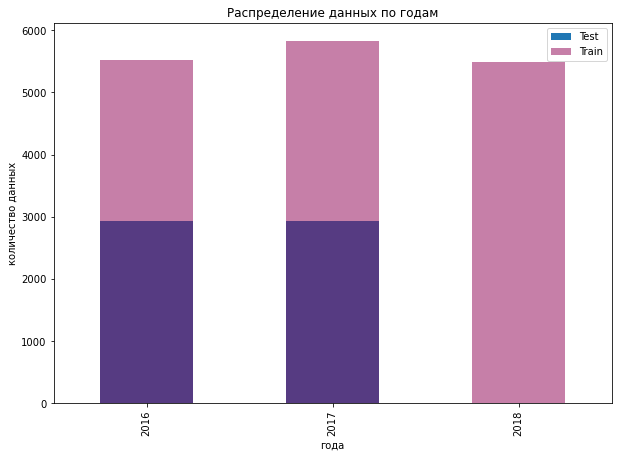

In [8]:
# распределение данных по годам/по исходным данным

ax_test = g_test.index.year.value_counts().sort_index().plot(kind = 'bar',title = 'Распределение данных по годам')
ax_train = g_train.index.year.value_counts().sort_index().plot(kind = 'bar',colormap = 'PiYG',alpha=0.5,figsize = (10,7))

plt.legend(['Test','Train'])

plt.xlabel('года')
plt.ylabel('количество данных')
plt.show()

Text(0.5, 0, 'Train')

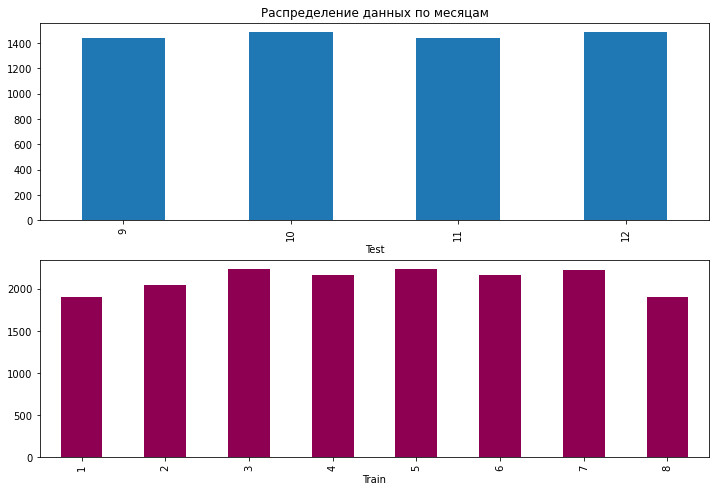

In [9]:
# распределение данных по месяцам/по исходным данным

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

g_test.index.month.value_counts().sort_index().plot(kind = 'bar',title = 'Распределение данных по месяцам',ax=axes[0])
g_train.index.month.value_counts().sort_index().plot(kind = 'bar',ax=axes[1],colormap = 'PiYG')


axes[0].set_xlabel('Test')
axes[1].set_xlabel('Train')


Test - сентябрь - декабрь  
Train - январь - август

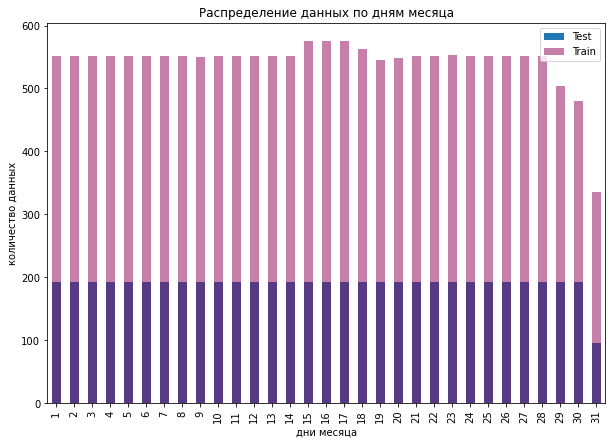

In [10]:
# распределение данных по дням месяца

ax_test = g_test.index.day.value_counts().sort_index().plot(kind = 'bar',title = 'Распределение данных по дням месяца')
ax_train = g_train.index.day.value_counts().sort_index().plot(kind = 'bar',colormap = 'PiYG',alpha=0.5,figsize = (10,7))



plt.legend(['Test','Train'])

plt.xlabel('дни месяца')
plt.ylabel('количество данных')
plt.show()



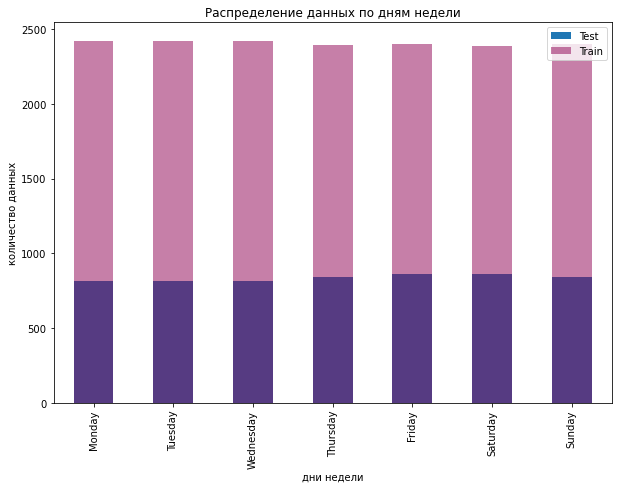

In [11]:
# распределение данных по дням месяца

ax_test = g_test.index.weekday.value_counts().sort_index().plot(kind = 'bar',title = 'Распределение данных по дням недели')
ax_train = g_train.index.weekday.value_counts().sort_index().plot(kind = 'bar',colormap = 'PiYG',alpha=0.5,figsize = (10,7))

plt.legend(['Test','Train'])

plt.xticks(np.arange(7),list(calendar.day_name))

plt.xlabel('дни недели')
plt.ylabel('количество данных')
plt.show()

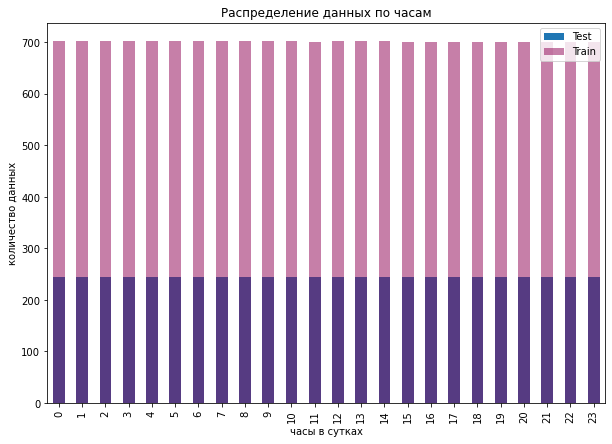

In [12]:
# распределение данных по часам


ax_test = g_test.index.hour.value_counts().sort_index().plot(kind = 'bar',title = 'Распределение данных по часам')
ax_train = g_train.index.hour.value_counts().sort_index().plot(kind = 'bar',colormap = 'PiYG',alpha=0.5,figsize = (10,7))

plt.legend(['Test','Train'])


plt.xlabel('часы в сутках')
plt.ylabel('количество данных')
plt.show()




Данные распредлены равномерно по дням и часам. По годам данные в тестовой выборке только за 2016 и 2017 года и только за период сентрябь - декабрь, в тренировочной с 2016 по 2018 года январь - август!

## Проверьте, что эффективность обогащения рассчитана правильно.Вычислите её на обучающей выборке для признака rougher.output.recovery. Найдите MAE между вашими расчётами и значением признака. Опишите выводы.

**Расчёт эффективности**  
Вам нужно смоделировать процесс восстановления золота из золотосодержащей руды.  
Эффективность обогащения рассчитывается по формуле  

![формула](https://pictures.s3.yandex.net/resources/Recovery_1576238822.jpg)
где:  
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки.  
Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [13]:
# функция расчитывает Эффективность обогащения
# если в знаменателе 0, меняем на значение из исходной таблицы
def recovery_rougher(row):
    C = row['rougher.output.concentrate_au']
    F = row['rougher.input.feed_au']
    T = row['rougher.output.tail_au']
    Calc = row['rougher.output.recovery']
    if (F * (C-T)) == 0: R = Calc
    
    else: R = 100* ((C * (F-T)) / (F * (C-T)))   
    return R


In [14]:
# рассчитаем Recovery для этапа флотация
g_train['rougher.calculation.recovery'] = g_train.apply(recovery_rougher,axis=1)

In [15]:
# прежде чем посчитать mae нужно определить не пустые ячейки
mae_index = g_train['rougher.output.recovery'].notna()

In [16]:
# проверим количество пропусков:
print(g_train.loc[mae_index]['rougher.calculation.recovery'].isna().sum())
print(g_train.loc[mae_index]['rougher.output.recovery'].isna().sum())

0
0


In [17]:
mean_absolute_error(g_train.loc[mae_index]['rougher.output.recovery'],g_train.loc[mae_index]['rougher.calculation.recovery'])

9.444891926100695e-15

### Подитог:  
Значение MAE стремится к 0,это значит наши расчеты совпадают с признаком rougher.output.recovery.
Соответственно считаем что в дальнейшем данная формула есть эталон для расчетов

## Проанализируйте признаки, недоступные в тестовой выборке. Что это за параметры? К какому типу относятся?

In [18]:
#uniq_train_cols = []
#for i in g_train.columns:
#    if i not in g_test.columns:
#        uniq_train_cols.append(i)

# uniq_train_cols

In [19]:
# список отсутсвующих колонок в тесте
# дублирую здесь, выполнил выше в п.1.1
set(g_train.columns)-set(g_test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.recovery',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.out

### Подитог: 
~~В тестовой выборке отсутствуют:~~
~~- выходные параметры готового продукта/сырья/отвалов на всех этапах (флотация, 2 очистки и готовая продукция). Это все измеряемые параметры;~~
~~- расчетные характеристики эффективности обогащения: **final.output.recovery, rougher.output.recovery**. Это есть 2 наших таргет признака. Это рассчетные параметры;  ~~
~~- расчитанная нами характеристика эффективности обогащения после флотации rougher.calculation.recovery. Это рассчетный параметр.~~

**UPD**:
- в тесте нет 34 колонок из трейн, из них 2 колонки это таргет (final.output.recovery, rougher.output.recovery), остальные признаки:
 - выходные концентрации веществ на этапах (rougher/primary_cleaner/final.output.concentrate_хх) - 12 колонок;
 - выходные концентрации отвальных хвостов на всех этапах (rougher/primary_cleaner/secondary_cleaner/final.output.tail_хх) - 16 колонок;
 - расчетны характеристики на этапе флотации 4 колонки:(rougher.calculation.au_pb_ratio/floatbank10_sulfate_to_au_feed/floatbank11_sulfate_to_au_feed/sulfate_to_au_concentrate)
- вытащим из full только 2 колонки с таргетом для test.

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    
    
    
копия из п.1.1.    
 изменил способ формирования/количество столбцов в тест
</div>

## Проведите предобработку данных

### Работа с пропусками.

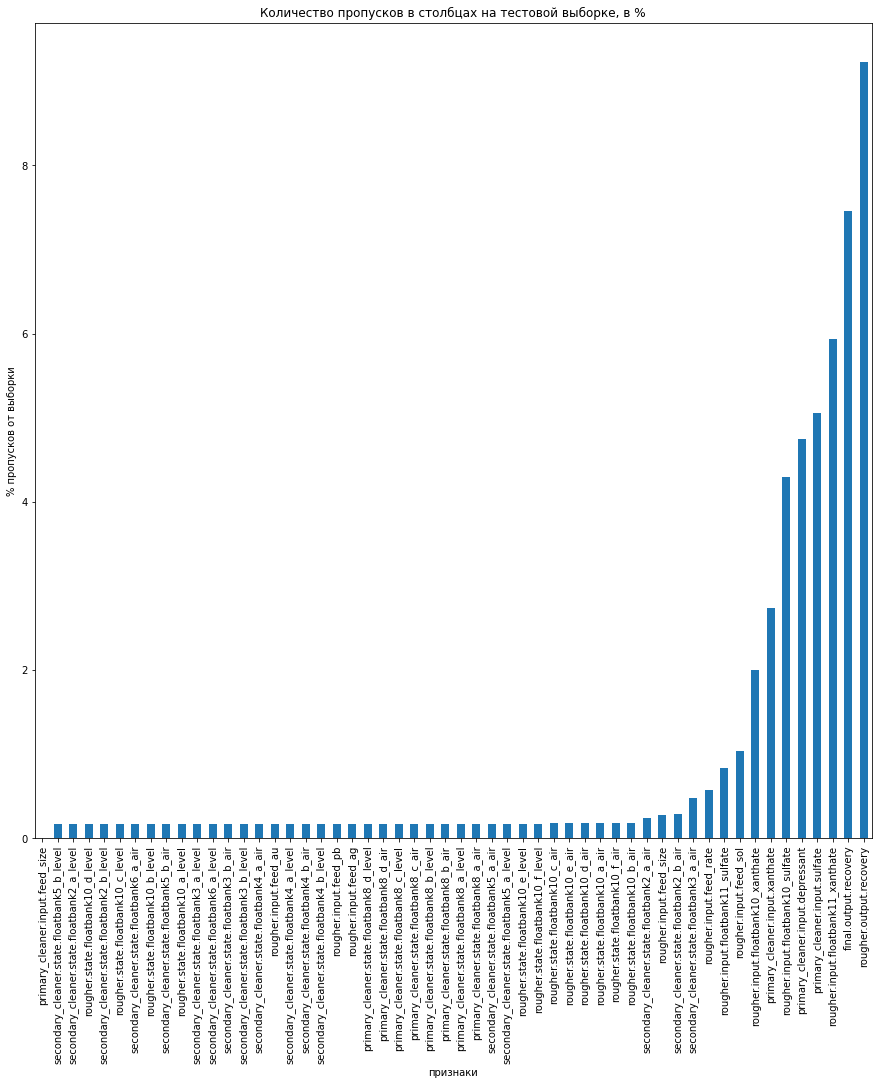

In [20]:
# количество пропусков по столбцам на тестовой выборке % от общей выборки

(100* g_test_upd.isna().sum()/g_test_upd.shape[0]).sort_values().\
plot(kind = 'bar',figsize = (15,15), title = 'Количество пропусков в столбцах на тестовой выборке, в %')
#plt.legend(['Train','Test','Full'])

plt.xlabel('признаки')
plt.ylabel('% пропусков от выборки')
plt.show()
#  максимально 8+% выбросов
# максимальное количество пропусков это наши таргеты 1,2 место (final.output.recovery, rougher.output.recovery)
# таргеты лучше не изменять, а просто удалять

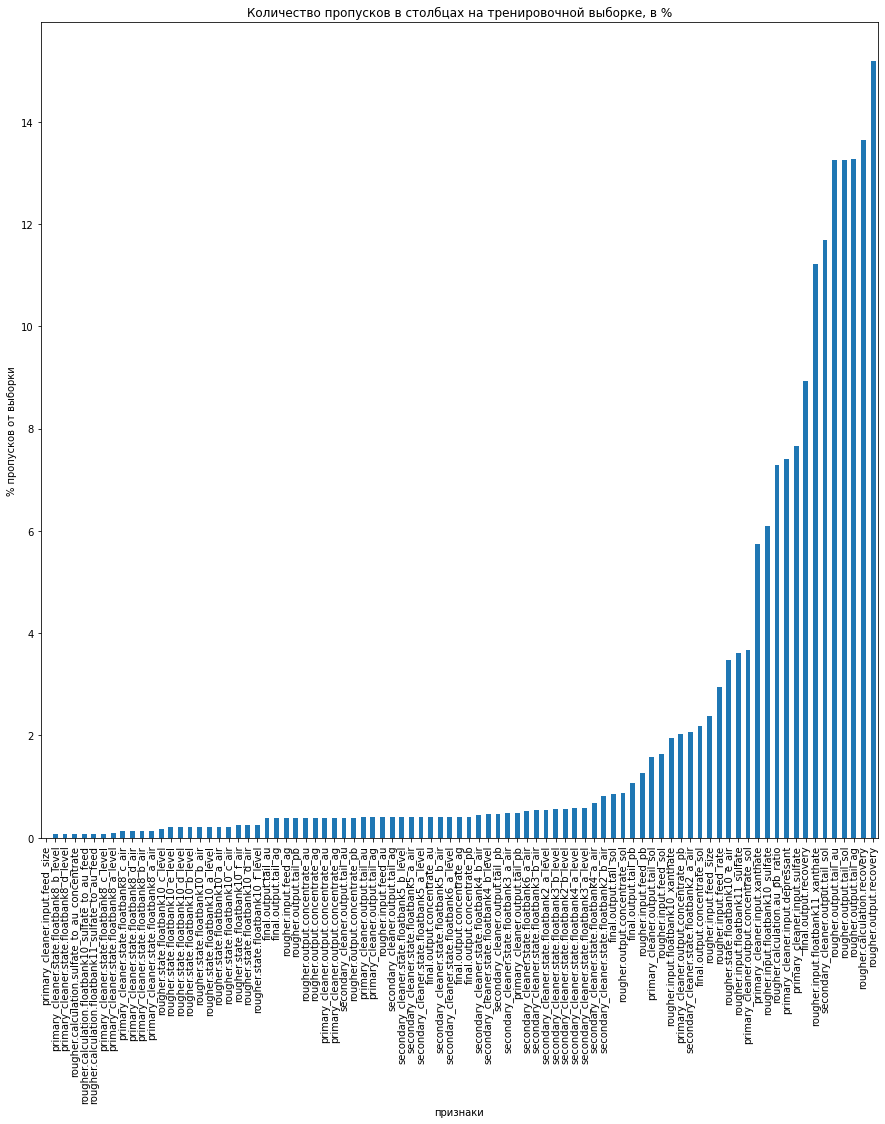

In [21]:
# количество пропусков по столбцам на тренировочной выборке % от общей выборки
(100*g_train.isna().sum()/g_train.shape[0]).sort_values().\
plot(kind = 'bar',figsize = (15,15),title = 'Количество пропусков в столбцах на тренировочной выборке, в %')


plt.xlabel('признаки')
plt.ylabel('% пропусков от выборки')
plt.show()
#  максимально около 15% выбросов
# максимальное количество пропусков это 1 из таргетов rougher.output.recovery
# в другом таргете пропусков около 9%, что тоже не мало
# таргеты лучше не изменять, а просто удалять

In [22]:
# 31369 пропусков
print(g_train.isna().sum().sum())

# 3030 пропусков
print(g_test_upd.isna().sum().sum())

31369
3030


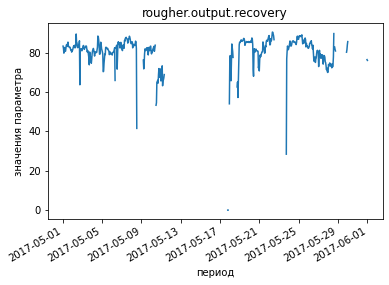

In [23]:
# видны просадки/отсутствие значений
# период взят на угад
g_train['2017-05-01':'2017-05-31']['rougher.output.recovery'].plot(title = 'rougher.output.recovery')

plt.xlabel('период')
plt.ylabel('значения параметра')
plt.show()

In [24]:
# данные формируются каждый час с датчиков
# если усреднить данные методом resample, а оставшиеся пропуски заполнит методом ffill , то тем самым получим 
# более надежные данные, чем просто ffill

#g_train = g_train.resample('3h').mean().ffill(axis=0)
#g_test_upd = g_test_upd.resample('3h').mean().ffill(axis=0)

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- уйдем от ресемплирования и останемся на часовых интервалах;
- сначала удалим пропуски в таргетах, дальше посмотри что будет с остальными признаками    
    
</div>

In [25]:
print(g_train.shape,g_test_upd.shape)

(16844, 87) (5850, 54)


In [26]:
train_drop_index = g_train[g_train['rougher.output.recovery'].isna() | g_train['final.output.recovery'].isna()].index
test_drop_index = g_test_upd[g_test_upd['rougher.output.recovery'].isna() | g_test_upd['final.output.recovery'].isna()].index

print(train_drop_index.shape,test_drop_index.shape)

(2695,) (560,)


In [27]:

g_train = g_train.drop(labels=train_drop_index)
g_test_upd = g_test_upd.drop(labels=test_drop_index)

print(g_train.shape,g_test_upd.shape)

(14149, 87) (5290, 54)


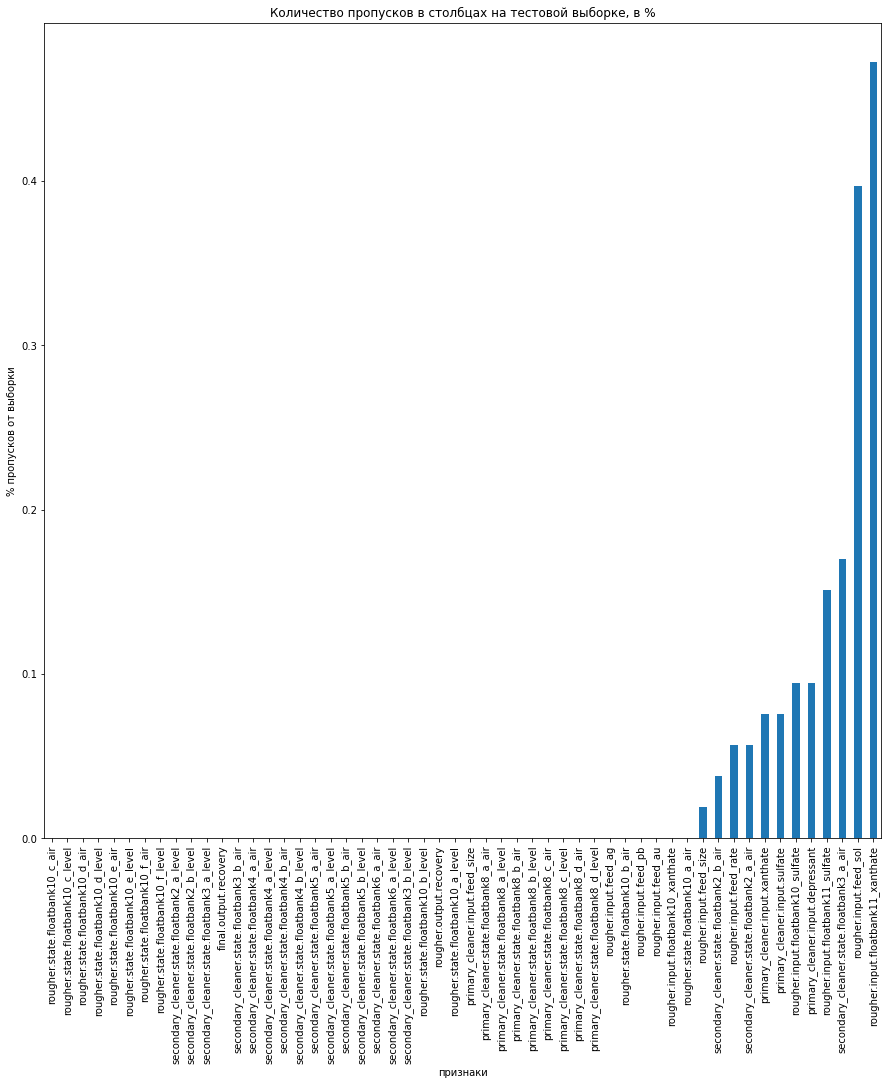

In [28]:
# количество пропусков по столбцам на тестовой выборке % от общей выборки

(100* g_test_upd.isna().sum()/g_test_upd.shape[0]).sort_values().\
plot(kind = 'bar',figsize = (15,15), title = 'Количество пропусков в столбцах на тестовой выборке, в %')
#plt.legend(['Train','Test','Full'])

plt.xlabel('признаки')
plt.ylabel('% пропусков от выборки')
plt.show()

#  максимально 0,5% выбросов в признаках


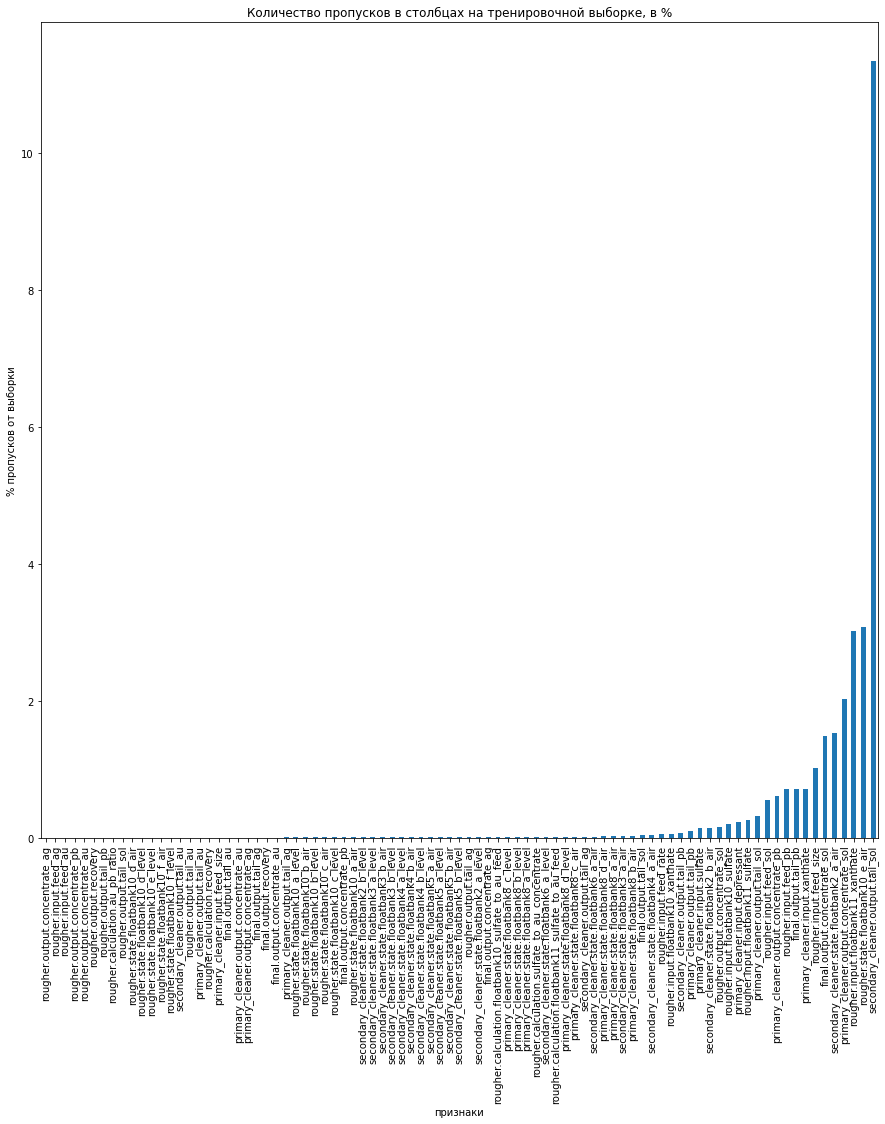

In [29]:
# количество пропусков по столбцам на тренировочной выборке % от общей выборки
(100*g_train.isna().sum()/g_train.shape[0]).sort_values().\
plot(kind = 'bar',figsize = (15,15),title = 'Количество пропусков в столбцах на тренировочной выборке, в %')


plt.xlabel('признаки')
plt.ylabel('% пропусков от выборки')
plt.show()

#  максимально около 12% выбросов по одному признаку secondary_cleaner.output.tail_sol
# в остальном не более 3 %


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- остальные признаки заполним методом interpolate(method='time')
    
</div>

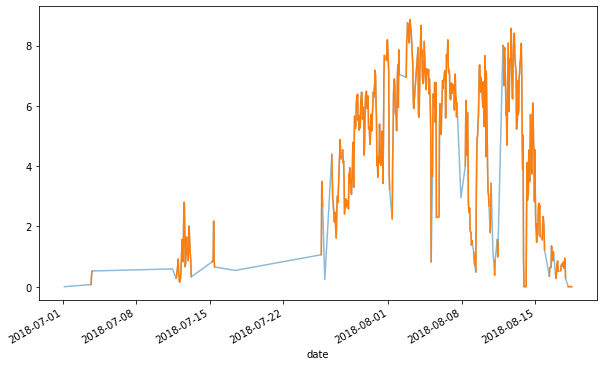

In [30]:
# попробовал разные методы, заполню методом interpolate(method='time')
# график как пример приведен

#g_train['2018-07':'2018-09']['secondary_cleaner.output.tail_sol'].interpolate(method='linear').plot(alpha = 0.3,figsize = (10,6))
g_train['2018-07':'2018-09']['secondary_cleaner.output.tail_sol'].interpolate(method='time').plot(alpha = 0.5,figsize = (10,6))

g_train['2018-07':'2018-09']['secondary_cleaner.output.tail_sol'].plot()

In [31]:
g_train = g_train.interpolate(method='time')
g_test_upd = g_test_upd.interpolate(method='time')

In [32]:
# 0 пропусков
print(g_train.isna().sum().sum())

# 0 пропусков
print(g_test_upd.isna().sum().sum())

0
0


In [33]:


#from sklearn.decomposition import PCA
#X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
#pca = PCA(n_components=4,random_state=RNS)
#pca.fit(g_test.resample('6m').mean())
#PCA(n_components=3)
#print(pca.explained_variance_ratio_)
#[0.9924... 0.0075...]
#print(pca.singular_values_)
#[6.30061... 0.54980...]

#X[4][0]

#### Подитог (UPD): 
- в тестовой и тренировочной выборках выявлены пропуски, основное количество в тагет признаках;
- считаю что выдумывать данные для таргета не корректно, поэтому удалили все пропуски в таргетах;
- в оставшихся пропусках в признаках заполнил пропуски методом interpolate(method='time');
~~- выполнил усреднение по 3 часа методом resample и остальные пропуски заполнил методом ffill;~~


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- при работе с пропусками вернулся к 1 часовому датасету;
- теперь тест имеют исходную размерность + 2 колонки таргетов.    
    
</div>

# Анализ данных

## Посмотрите, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки. Опишите выводы

In [34]:
# функция для формирования списка колонок в зависимости от этапа/типа параметра.

def cols_name(df):
    final = []
    primary_cleaner = []
    rougher = []
    secondary_cleaner = []
    other_stage = []
    input_list = []
    output = []
    state = []
    calculation = []
    other_params = []
    for i in df.columns:
        if 'final' in i: final.append(i)
        elif  'primary_cleaner' in i: primary_cleaner.append(i)
        elif  'rougher' in i: rougher.append(i)  
        elif  'secondary_cleaner' in i: secondary_cleaner.append(i)
        else: other_stage.append(i)
            
        if 'input' in i: input_list.append(i)
        elif  'output' in i: output.append(i)
        elif  'state' in i: state.append(i)  
        elif  'calculation' in i: calculation.append(i)
        else: other_params.append(i)
    return final,primary_cleaner,rougher,secondary_cleaner,other_stage,input_list,output,state,calculation,other_params   


In [35]:
ag_list = []
au_list = []
pb_list = []
sol_list = []
for i in g_train.columns:
    if 'ag' in i:
        ag_list.append(i)
    if 'au' in i:
        au_list.append(i)
    if 'pb' in i:
        pb_list.append(i)
    if 'sol' in i:
        sol_list.append(i)   

In [36]:
ag_list
au_list
pb_list
sol_list

['final.output.concentrate_sol',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_sol',
 'rougher.input.feed_sol',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_sol',
 'secondary_cleaner.output.tail_sol']

In [37]:
# функция строит 3 графика плотности. Деление идет по этапам (rougher,primary_cleaner,final)
def plot_distplot(df,col1,col2,col3,title): # legend1,legend2,legend3
    fig = plt.figure(figsize=(10,6))
    sns.distplot(df[col1])
    sns.distplot(df[col2])
    sns.distplot(df[col3])

    fig.legend([col1,col2,col3])
    plt.xlabel(title)
    plt.ylabel('значения параметра')
    plt.show()
    


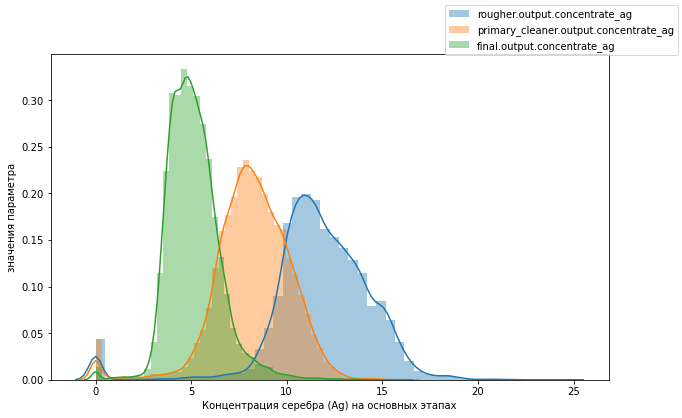

In [38]:
plot_distplot(df = g_train,
              col1 = 'rougher.output.concentrate_ag',
              col2 = 'primary_cleaner.output.concentrate_ag',
              col3 = 'final.output.concentrate_ag',
              title = 'Концентрация серебра (Ag) на основных этапах',
)

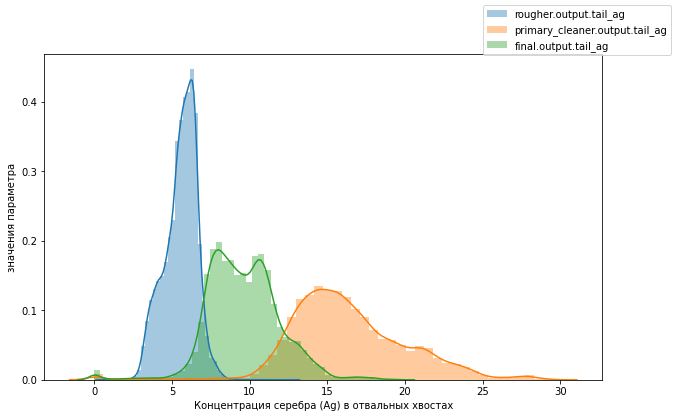

In [39]:
plot_distplot(df = g_train,
              col1 = 'rougher.output.tail_ag',
              col2 = 'primary_cleaner.output.tail_ag',
              col3 = 'final.output.tail_ag',
              title = 'Концентрация серебра (Ag) в отвальных хвостах',
)

In [40]:
# функция строит 3 графика. Деление идет по этапам (rougher,primary_cleaner,final)
#def plot_graph(df,date_range1,date_range2,col1,col2,col3,title,legend1,legend2,legend3):
#    df[date_range1:date_range2][col1].plot(kind = 'line', title = title,figsize = (12,12))
#    df[date_range1:date_range2][col2].plot(kind = 'line')
#    df[date_range1:date_range2][col3].plot(kind = 'line')
#    plt.legend([legend1,legend2,legend3],loc=1)
#    plt.xlabel('период')
#    plt.ylabel('значения параметра')
#    plt.show()

In [41]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-01',
#           date_range2 = '2017-03-15',
#           col1 = 'rougher.output.concentrate_ag',
#           col2 = 'primary_cleaner.output.concentrate_ag',
#           col3 = 'final.output.concentrate_ag',
#           title = 'Концентрация серебра (Ag)',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

In [42]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-05',
#           date_range2 = '2017-03-07',
#           col1 = 'rougher.output.concentrate_ag',
#           col2 = 'primary_cleaner.output.concentrate_ag',
#           col3 = '#',
#           title = 'Концентрация серебра (Ag)',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

In [43]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-01',
#           date_range2 = '2017-03-15',
#           col1 = 'rougher.output.tail_ag',
#           col2 = 'primary_cleaner.output.tail_ag',
#           col3 = 'final.output.tail_ag',
#           title = 'Концентрация серебра (Ag) в отвальных хвостах',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

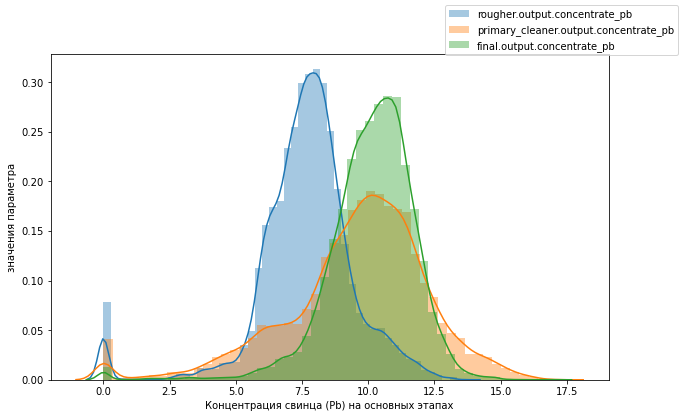

In [44]:
plot_distplot(df = g_train,
              col1 = 'rougher.output.concentrate_pb',
              col2 = 'primary_cleaner.output.concentrate_pb',
              col3 = 'final.output.concentrate_pb',
              title = 'Концентрация свинца (Pb) на основных этапах',
)

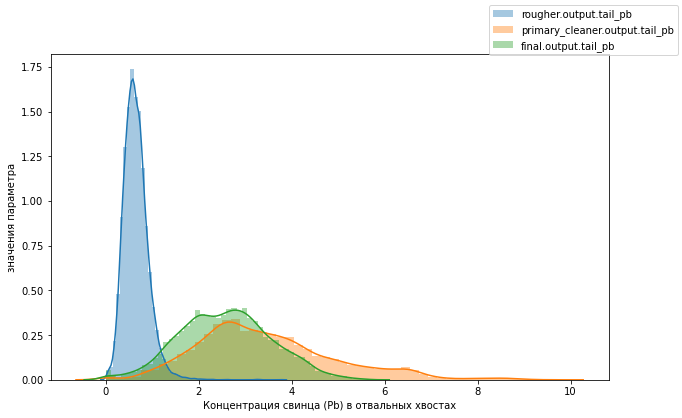

In [45]:
plot_distplot(df = g_train,
              col1 = 'rougher.output.tail_pb',
              col2 = 'primary_cleaner.output.tail_pb',
              col3 = 'final.output.tail_pb',
              title = 'Концентрация свинца (Pb) в отвальных хвостах',
)

In [46]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-01',
#           date_range2 = '2017-03-15',
#           col1 = 'rougher.output.concentrate_pb',
#           col2 = 'primary_cleaner.output.concentrate_pb',
#           col3 = 'final.output.concentrate_pb',
#           title = 'Концентрация свинца (Pb)',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )



In [47]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-06',
#           date_range2 = '2017-03-08',
#           col1 = 'rougher.output.concentrate_pb',
#           col2 = 'primary_cleaner.output.concentrate_pb',
#           col3 = 'final.output.concentrate_pb',
#           title = 'Концентрация свинца (Pb)',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )


In [48]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-01',
#           date_range2 = '2017-03-15',
#           col1 = 'rougher.output.tail_pb',
#           col2 = 'primary_cleaner.output.tail_pb',
#           col3 = 'final.output.tail_pb',
#           title = 'Концентрация свинца (Pb) в отвальных хвостах',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

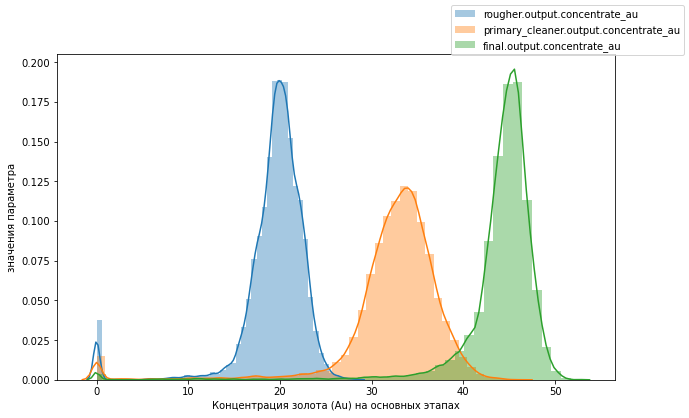

In [49]:
plot_distplot(df = g_train,
              col1 = 'rougher.output.concentrate_au',
              col2 = 'primary_cleaner.output.concentrate_au',
              col3 = 'final.output.concentrate_au',
              title = 'Концентрация золота (Au) на основных этапах',
)

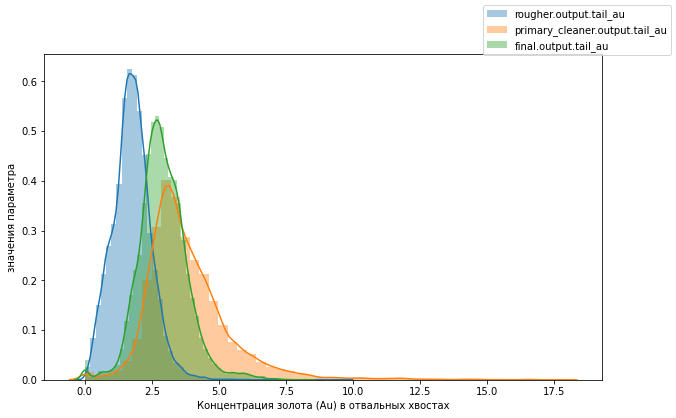

In [50]:
plot_distplot(df = g_train,
              col1 = 'rougher.output.tail_au',
              col2 = 'primary_cleaner.output.tail_au',
              col3 = 'final.output.tail_au',
              title = 'Концентрация золота (Au) в отвальных хвостах',
)

In [51]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-01',
#           date_range2 = '2017-03-15',
#           col1 = 'rougher.output.concentrate_au',
#           col2 = 'primary_cleaner.output.concentrate_au',
#           col3 = 'final.output.concentrate_au',
#           title = 'Концентрация золота (Au)',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

In [52]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-06',
#           date_range2 = '2017-03-07',
#           col1 = 'rougher.output.concentrate_au',
#           col2 = 'primary_cleaner.output.concentrate_au',
#           col3 = 'final.output.concentrate_au',
#           title = 'Концентрация золота (Au)',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

In [53]:
#plot_graph(df = g_train,
#           date_range1 = '2017-03-01',
#           date_range2 = '2017-03-15',
#           col1 = 'rougher.output.tail_au',
#           col2 = 'primary_cleaner.output.tail_au',
#           col3 = 'final.output.tail_au',
#           title = 'Концентрация золота (Au) в отвальных хвостах',
#           legend1 = 'rougher.output',
#           legend2 = 'primary_cleaner.output',
#           legend3 = 'final.output'
#          )

### Подитог: UPD
- Au:
 - концентрация золота в породе с каждым этап возрастает, это логично т.к. часть пустой породы уходит в хвосты. Концентрация от флотации до готового продукта увеличивается более чем в 2,5 раза; в отвальных хвостах концентрации почти не меняется.
- Ag:
 - концентрация серебра в породе с каждым этап падает, а в хвостах наоборот возрастает;
- Pb:
 - концентрация свинца увеличивается с каждым этапом, аналогично в отвальных хвостах.

## Сравните распределения размеров гранул сырья на обучающей и тестовой выборках. Если распределения сильно отличаются друг от друга, оценка модели будет неправильной.

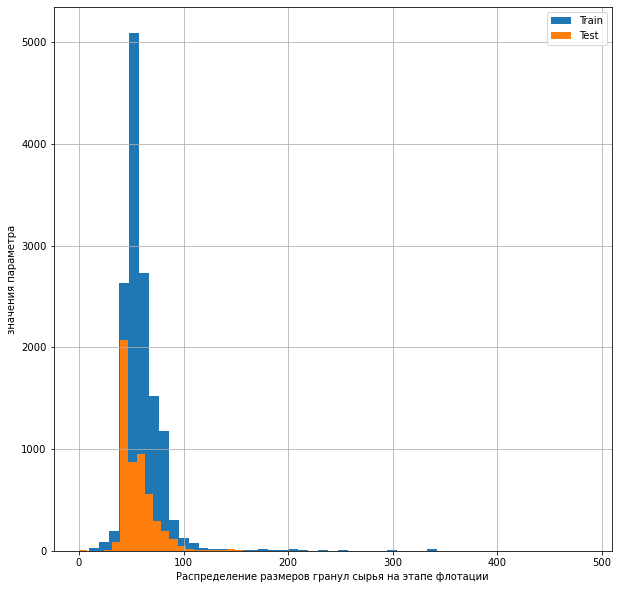

In [54]:
g_train['rougher.input.feed_size'].hist(bins=50,figsize=(10,10))
g_test_upd['rougher.input.feed_size'].hist(bins=50)

plt.legend(['Train','Test'])
plt.xlabel('Распределение размеров гранул сырья на этапе флотации')
plt.ylabel('значения параметра')
plt.show()

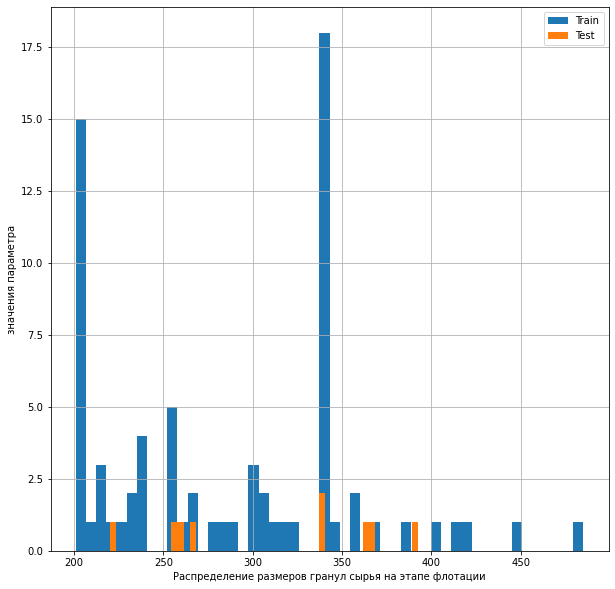

In [55]:
g_train[g_train['rougher.input.feed_size']>200]['rougher.input.feed_size'].hist(bins=50,figsize=(10,10))
g_test_upd[g_test_upd['rougher.input.feed_size']>200]['rougher.input.feed_size'].hist(bins=50)

plt.legend(['Train','Test'])
plt.xlabel('Распределение размеров гранул сырья на этапе флотации')
plt.ylabel('значения параметра')
plt.show()

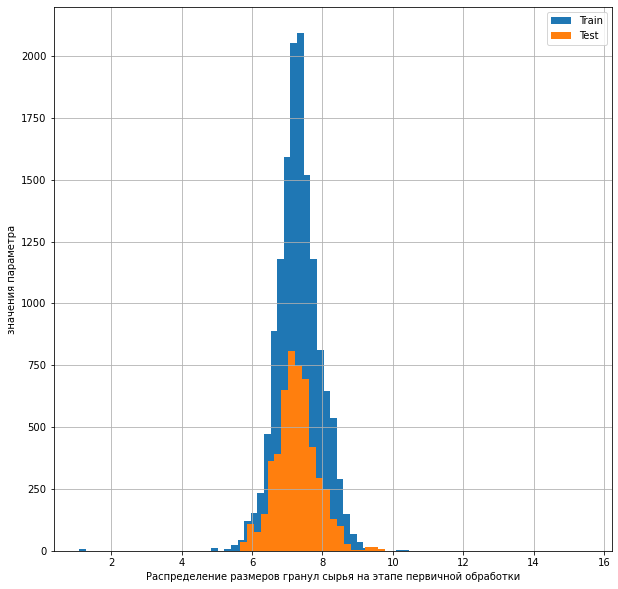

In [56]:
g_train['primary_cleaner.input.feed_size'].hist(bins=50,figsize=(10,10))
g_test_upd['primary_cleaner.input.feed_size'].hist(bins=50)

plt.legend(['Train','Test'])
plt.xlabel('Распределение размеров гранул сырья на этапе первичной обработки')
plt.ylabel('значения параметра')
plt.show()

### Подитог: UPD
- распределения для тестовой и тренировочной похожи!
- на первичной обработке диапазон размеров гранул сильно сужается по сравнению с флотацией, мода была в районе 50, упала в район 7 единиц.
- на этапе флотации на обоих выборках видны возможно выбросы на уровне > 200. т.к. это есть в обоих выборках, пока оставляем.

## Исследуйте суммарную концентрацию всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах. Заметили аномальные значения в суммарном распределении или нет? Если они есть, стоит ли их удалять из обеих выборок? Опишите выводы и удалите аномалии.

In [57]:
# функции ниже суммарную концентрацию всех веществ на разных стадиях:
def total_concentrate_rougher(row):
    ag = row['rougher.output.concentrate_ag']
    pb = row['rougher.output.concentrate_pb']
    au = row['rougher.output.concentrate_au']
    sol = row['rougher.output.concentrate_sol']
    r = ag+pb+au+sol
    return r


In [58]:
def total_concentrate_rougher_tail(row):
    ag = row['rougher.output.tail_ag']
    pb = row['rougher.output.tail_pb']
    au = row['rougher.output.tail_au']
    sol = row['rougher.output.tail_sol']
    r = ag+pb+au+sol
    return r

In [59]:
def total_concentrate_primary(row):
    ag = row['primary_cleaner.output.concentrate_ag']
    pb = row['primary_cleaner.output.concentrate_pb']
    au = row['primary_cleaner.output.concentrate_au']
    sol = row['primary_cleaner.output.concentrate_sol']
    r = ag+pb+au+sol
    return r


In [60]:
def total_concentrate_primary_tail(row):
    ag = row['primary_cleaner.output.tail_ag']
    pb = row['primary_cleaner.output.tail_pb']
    au = row['primary_cleaner.output.tail_au']
    sol = row['primary_cleaner.output.tail_sol']
    r = ag+pb+au+sol
    return r

In [61]:
def total_concentrate_final(row):
    ag = row['final.output.concentrate_ag']
    pb = row['final.output.concentrate_pb']
    au = row['final.output.concentrate_au']
    sol = row['final.output.concentrate_sol']
    r = ag+pb+au+sol
    return r

In [62]:
def total_concentrate_final_tail(row):
    ag = row['final.output.tail_ag']
    pb = row['final.output.tail_pb']
    au = row['final.output.tail_au']
    sol = row['final.output.tail_sol']
    r = ag+pb+au+sol
    return r

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- код не менял, только закомментировал тест
    
</div>

In [63]:
g_train['rougher.output.concentrate.total'] = g_train.apply(total_concentrate_rougher,axis=1)
g_train['rougher.output.tail.total'] = g_train.apply(total_concentrate_rougher_tail,axis=1)

#g_test_upd['rougher.output.concentrate.total'] = g_test_upd.apply(total_concentrate_rougher,axis=1)
#g_test_upd['rougher.output.tail.total'] = g_test_upd.apply(total_concentrate_rougher_tail,axis=1)


g_train['primary_cleaner.output.concentrate.total'] = g_train.apply(total_concentrate_primary,axis=1)
g_train['primary_cleaner.output.tail.total'] = g_train.apply(total_concentrate_primary_tail,axis=1)

#g_test_upd['primary_cleaner.output.concentrate.total'] = g_test_upd.apply(total_concentrate_primary,axis=1)
#g_test_upd['primary_cleaner.output.tail.total'] = g_test_upd.apply(total_concentrate_primary_tail,axis=1)


g_train['final.output.concentrate.total'] = g_train.apply(total_concentrate_final,axis=1)
g_train['final.output.tail.total'] = g_train.apply(total_concentrate_final_tail,axis=1)

#g_test_upd['final.output.concentrate.total'] = g_test_upd.apply(total_concentrate_final,axis=1)
#g_test_upd['final.output.tail.total'] = g_test_upd.apply(total_concentrate_final_tail,axis=1)


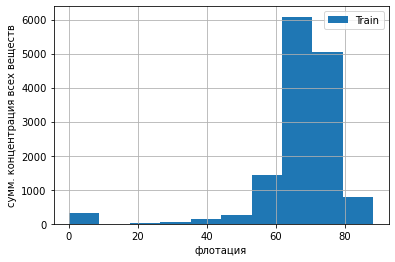

In [64]:
g_train['rougher.output.concentrate.total'].hist()
#g_test_upd['rougher.output.concentrate.total'].hist()

plt.legend(['Train','Test'])
plt.xlabel('флотация')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()


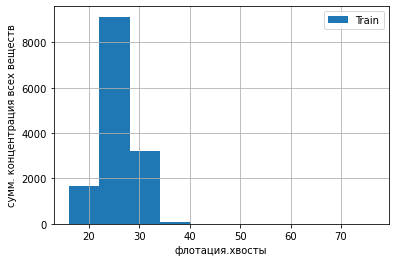

In [65]:
g_train['rougher.output.tail.total'].hist()
#g_test_upd['rougher.output.tail.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('флотация.хвосты')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

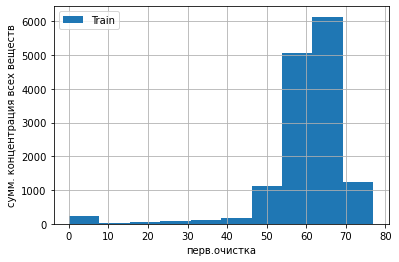

In [66]:
g_train['primary_cleaner.output.concentrate.total'].hist()
#g_test_upd['primary_cleaner.output.concentrate.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('перв.очистка')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

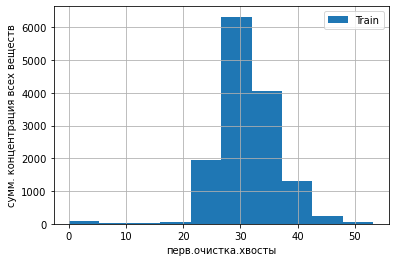

In [67]:
g_train['primary_cleaner.output.tail.total'].hist()
#g_test_upd['primary_cleaner.output.tail.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('перв.очистка.хвосты')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

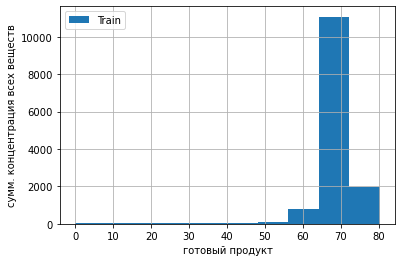

In [68]:
g_train['final.output.concentrate.total'].hist()
#g_test_upd['final.output.concentrate.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('готовый продукт')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

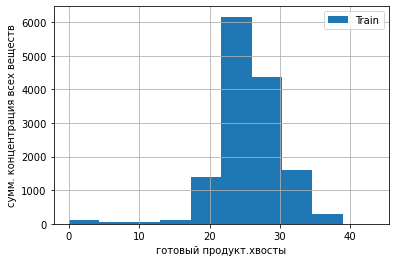

In [69]:
g_train['final.output.tail.total'].hist()
#g_test_upd['final.output.tail.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('готовый продукт.хвосты')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

### Подитог: UPD
- во всех распределниях очевидно, что есть выбросы на минимальных значениях. Как на ~~тестовой~~ так и на тренировочной выборке;
- это просматривается и на главных параметрах и в хвостах;
- требуется почистить строки со значениями ниже определенного уровня, возможно это один и тот же период!

UPD: т.к. изменился состав признаков на тесте, исследования проводились только для трейн

In [70]:
print(g_train.shape)

(14149, 93)


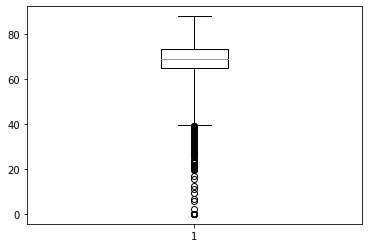

In [71]:
# +/- 3*IQR
plt.boxplot(g_train['rougher.output.concentrate.total'],whis = 3,widths = 0.2)
plt.show()

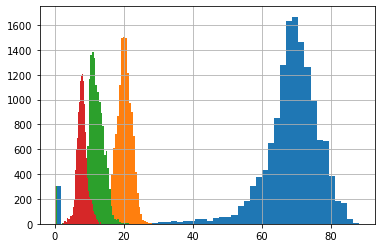

In [72]:
# посмотрим распредление по параметрам, убедимся что все параметры имеют выброс около 0
g_train['rougher.output.concentrate.total'].hist(bins=50)
g_train['rougher.output.concentrate_au'].hist(bins=50)
g_train['rougher.output.concentrate_ag'].hist(bins=50)
g_train['rougher.output.concentrate_pb'].hist(bins=50)

# кажется это что-то около 0


In [73]:
#print(g_train['rougher.output.concentrate.total'].quantile(0.01),
#g_train['primary_cleaner.output.concentrate.total'].quantile(0.01),
#g_train['final.output.concentrate.total'].quantile(0.01))
#


In [74]:
#print(g_train['rougher.output.concentrate.total'].quantile(0.99),
#g_train['primary_cleaner.output.concentrate.total'].quantile(0.99),
#g_train['final.output.concentrate.total'].quantile(0.99))

In [75]:
#g_train[g_train['rougher.output.concentrate.total']<10]['rougher.output.concentrate.total'].hist(bins=50)
#g_test_upd[g_test_upd['rougher.output.concentrate.total']<10]['rougher.output.concentrate.total'].hist(bins=50)

In [76]:
#g_train[g_train['rougher.output.concentrate.total']<2]['rougher.output.concentrate.total'].hist(bins=50)
#g_test_upd[g_test_upd['rougher.output.concentrate.total']<2]['rougher.output.concentrate.total'].hist(bins=50)

значения для отсечения выбирал исходя из графиков ящик с усами

% строк от выборки , которые будут удалены 3.61863029189342


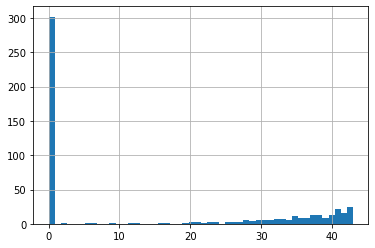

In [77]:

g_train[g_train['rougher.output.concentrate.total']<=43]['rougher.output.concentrate.total'].hist(bins=50)

print('% строк от выборки , которые будут удалены',\
      g_train[g_train['rougher.output.concentrate.total']<=43]['rougher.output.concentrate.total'].shape[0]/g_train.shape[0]*100)



In [78]:
g_train_zero_index_rougher = g_train[g_train['rougher.output.concentrate.total']<=43]['rougher.output.concentrate.total'].index

print('удалено строк на этом этапе',len(g_train_zero_index_rougher))
print(g_train.shape)


удалено строк на этом этапе 512
(14149, 93)


In [79]:
# дропнем zero_index_rougher
g_train = g_train.drop(g_train_zero_index_rougher)
#g_test_upd = g_test_upd.drop(g_test_zero_index_rougher)

print(g_train.shape)
#print(g_test_upd.shape)

(13637, 93)


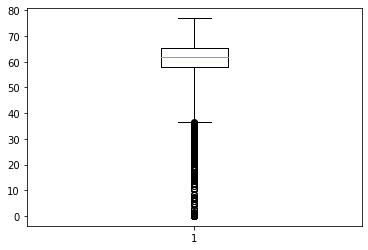

In [80]:
plt.boxplot(g_train['primary_cleaner.output.concentrate.total'],whis = 3,widths = 0.2)
plt.show()

% строк от выборки , которые будут удалены 2.8598665395614873


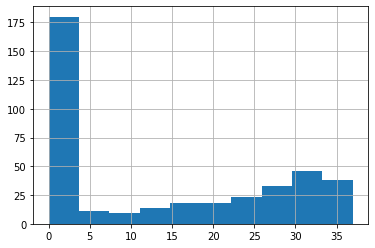

In [81]:
# методом подбора возьмем аналогичный кэф
g_train[g_train['primary_cleaner.output.concentrate.total']<=37]['primary_cleaner.output.concentrate.total'].hist()



print('% строк от выборки , которые будут удалены',\
g_train[g_train['primary_cleaner.output.concentrate.total']<=37]['primary_cleaner.output.concentrate.total'].shape[0]/g_train.shape[0]*100)
#g_test_upd[g_test_upd['primary_cleaner.output.concentrate_au']<0.5]['primary_cleaner.output.concentrate_au'].hist()

In [82]:
g_train_zero_index_primary = g_train[g_train['primary_cleaner.output.concentrate.total']<=37]['primary_cleaner.output.concentrate.total'].index
#g_test_zero_index_primary = g_test_upd[g_test_upd['primary_cleaner.output.concentrate_au']<0.5]['primary_cleaner.output.concentrate_au'].index


print('удалено строк на этом этапе',len(g_train_zero_index_primary))
#print(len(g_test_zero_index_primary))
print(g_train.shape)
#print(g_test_upd.shape)

удалено строк на этом этапе 390
(13637, 93)


In [83]:
# теперь дропнем zero_index_primary
g_train = g_train.drop(g_train_zero_index_primary)
#g_test_upd = g_test_upd.drop(g_test_zero_index_primary)

print(g_train.shape)
#print(g_test_upd.shape)

(13247, 93)


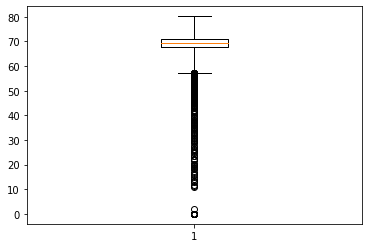

In [84]:
plt.boxplot(g_train['final.output.concentrate.total'],whis = 3,widths = 0.2)
plt.show()

% строк от выборки , которые будут удалены 0.7775345361213859


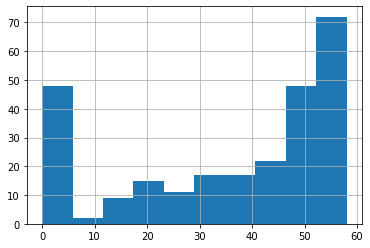

In [85]:
# методом подбора возьмем аналогичный кэф

g_train[g_train['final.output.concentrate.total']<=58]['final.output.concentrate.total'].hist()


print('% строк от выборки , которые будут удалены',\
g_train[g_train['final.output.concentrate.total']<=35]['final.output.concentrate.total'].shape[0]/g_train.shape[0]*100)
#g_test_upd[g_test_upd['final.output.concentrate.total']<0.5]['final.output.concentrate.total'].hist()

In [86]:
g_train_zero_index_final = g_train[g_train['final.output.concentrate.total']<=58]['final.output.concentrate.total'].index

#g_test_zero_index_final = g_test_upd[g_test_upd['final.output.concentrate.total']<0.5]['final.output.concentrate.total'].index

print('удалено строк на этом этапе',len(g_train_zero_index_final))
#print(len(g_test_zero_index_final))
print(g_train.shape)
#print(g_test_upd.shape)

удалено строк на этом этапе 261
(13247, 93)


In [87]:
# теперь дропнем zero_index_final
g_train = g_train.drop(g_train_zero_index_final)
#g_test_upd = g_test_upd.drop(g_test_zero_index_final)

print(g_train.shape)
#print(g_test_upd.shape)

(12986, 93)


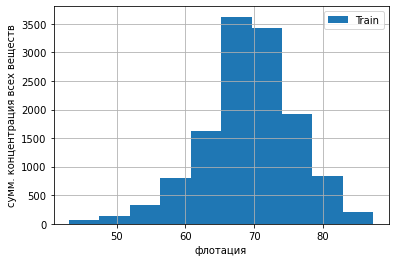

In [88]:
# проверим что изменилось
g_train['rougher.output.concentrate.total'].hist()
#g_test_upd['rougher.output.concentrate.total'].hist()


plt.legend(['Train','Test'])
plt.xlabel('флотация')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

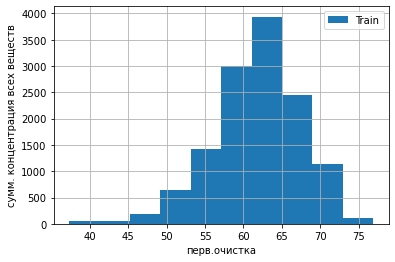

In [89]:
g_train['primary_cleaner.output.concentrate.total'].hist()
#g_test_upd['primary_cleaner.output.concentrate.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('перв.очистка')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

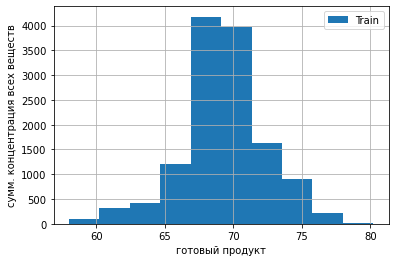

In [90]:
g_train['final.output.concentrate.total'].hist()
#g_test_upd['final.output.concentrate.total'].hist()

plt.legend(['Train','Test'])

plt.xlabel('готовый продукт')
plt.ylabel('сумм. концентрация всех веществ')
plt.show()

### Подитог: UPD
- почистил данные в диапазоне +/- 3*IQR, теперь аномалии отсутствуют, но хвосты смещены влево, только для train


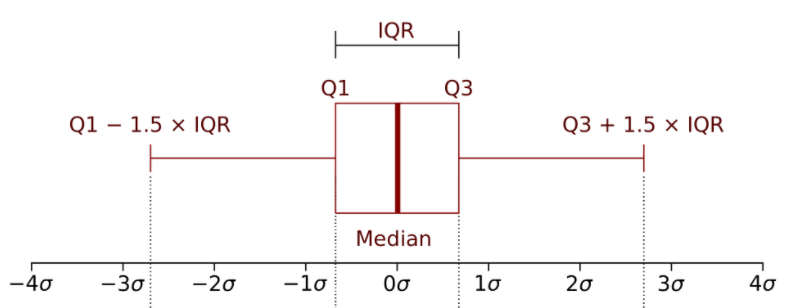

# Модель

### UPD. Удаляем признаки из трейн в соответствии с тест

In [91]:
g_train = g_train[g_test_upd.columns]

### Мультиколлинеарность признаков.
Считаем корреляцию между признаками более 0,9 мультиколлинеарностью и удаляем 1 из 2 коррелирующих признаков.  
Сначала делаем на тестовой выборке, далее на тренировочной, если потребуется.

In [92]:
# строим heatmap  по матрице корреляций между признаками в зависимости от уровня
# если значение ниже уровня, ставим 0,если выше оставляем значение
def correlation_heatmap(df,level):
    corr_total = df.corr().applymap(lambda x: 0 if x<=level else x)
    mask = np.zeros_like(corr_total)
    mask[np.triu_indices_from(mask)] = True
    with sns.axes_style("white"):
        f, ax = plt.subplots(figsize=(20, 20))
        ax = sns.heatmap(corr_total, mask=mask, square=True,annot=True)
        plt.title("All columns", fontsize =8)
        return plt.show()

In [93]:
# формируем матрицу корреляции в зависимости от уровня
# если значение ниже уровня, ставим 0,если выше 1
def corr_matrix(df,level):
    new_df = df.corr().applymap(lambda x: 0 if x<=level else 1)
    return new_df

#Corr_matrix_test = corr_matrix(g_test,0.9)
#Corr_matrix_train = corr_matrix(g_train,0.9)
#Corr_matrix_test.head()

In [94]:
# эти столбцы не трогаем
target_list = ['final.output.recovery','rougher.output.recovery']

In [95]:
# удаляем коррелирующие признаки и создаем новый DataFrame, выводим список удаленных столбцов
def del_corr_columns(df,sorted_list,level):
    matrix = corr_matrix(df=df,level=level)
    tmp_list = []
    for i in matrix[sorted_list].columns:
        if (matrix[i].sum() > 1) and (i not in target_list):
            df = df.drop(i,axis=1)
            matrix = corr_matrix(df=df,level=level)
            tmp_list.append(i)
            i = None
    return df,set(tmp_list)


In [96]:
# формируем список столбцов с корреляцией между собой > level
def most_correlation_list(df,level):
    matrix = corr_matrix(df=df,level=level)
    tmp_list = []
    for i in matrix.columns:
        if matrix[i].sum() > 1:
            tmp_list.append(i)
    return tmp_list


In [97]:
# создаем список столбцов отсортированных по дисперсии, от меньшей к большей
# лучше оставить столбцы в которых дисперсия максимальна
def var_min_max(df,tmp):
    var_dict = {}
    for i in tmp:
        var_dict[i] = df[i].var()
        
    sorted_dict = {k: v for k, v in sorted(var_dict.items(), key=lambda item: item[1])}    
    return list(sorted_dict.keys())

In [98]:
# объединяем работы функций выше и выводим новый DF и список удаленных столбцов
def multicollinearity(df,level):
    tmp_list = most_correlation_list(df,level)
    tmp_list_sorted = var_min_max(df[tmp_list],tmp_list)
    return del_corr_columns(df,tmp_list_sorted,level)

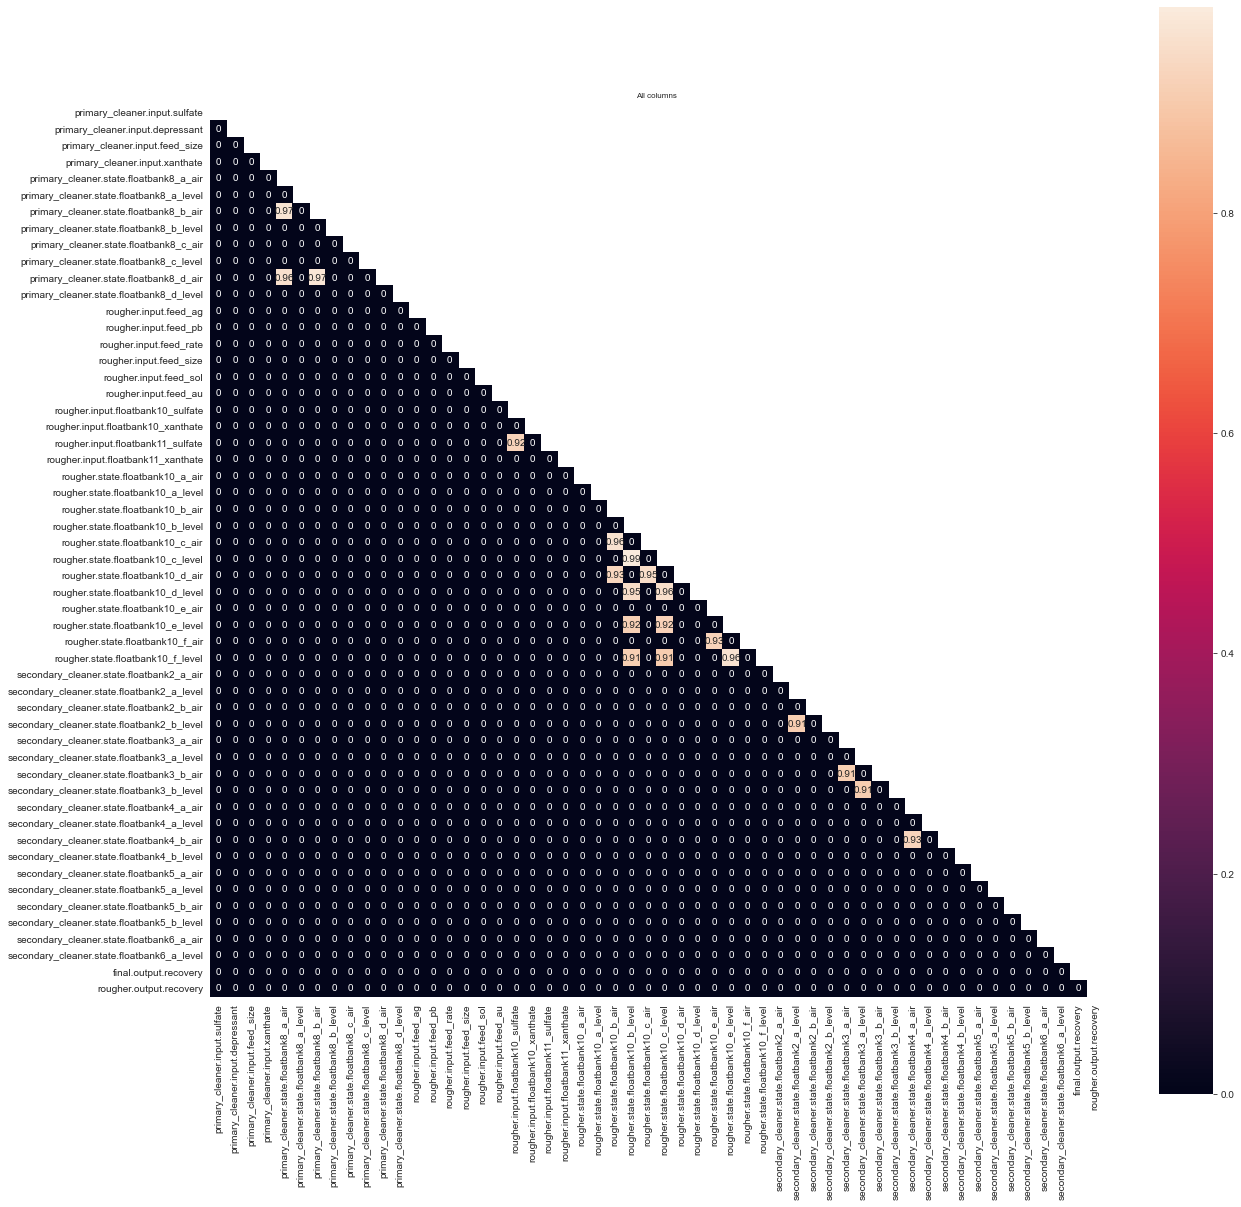

In [99]:
# предельный уровень корреляции между признаками
corr_level = 0.9
# исходная тестовая выборка
correlation_heatmap(g_test_upd,corr_level)
# высокая корреляция есть только в столбцах с данными о состоянии на различных этапах обработки

In [100]:
# удаляем столбцы с мультиколлинеарностью, выводим список удаленных столбцов
g_test_upd, test_drop_cols = multicollinearity(g_test_upd,corr_level)
test_drop_cols
#len(test_drop_cols)

{'primary_cleaner.state.floatbank8_a_air',
 'primary_cleaner.state.floatbank8_b_air',
 'rougher.input.floatbank11_sulfate',
 'rougher.state.floatbank10_b_air',
 'rougher.state.floatbank10_b_level',
 'rougher.state.floatbank10_c_air',
 'rougher.state.floatbank10_c_level',
 'rougher.state.floatbank10_e_level',
 'rougher.state.floatbank10_f_air',
 'secondary_cleaner.state.floatbank2_a_level',
 'secondary_cleaner.state.floatbank3_a_air',
 'secondary_cleaner.state.floatbank3_b_level',
 'secondary_cleaner.state.floatbank4_b_air'}

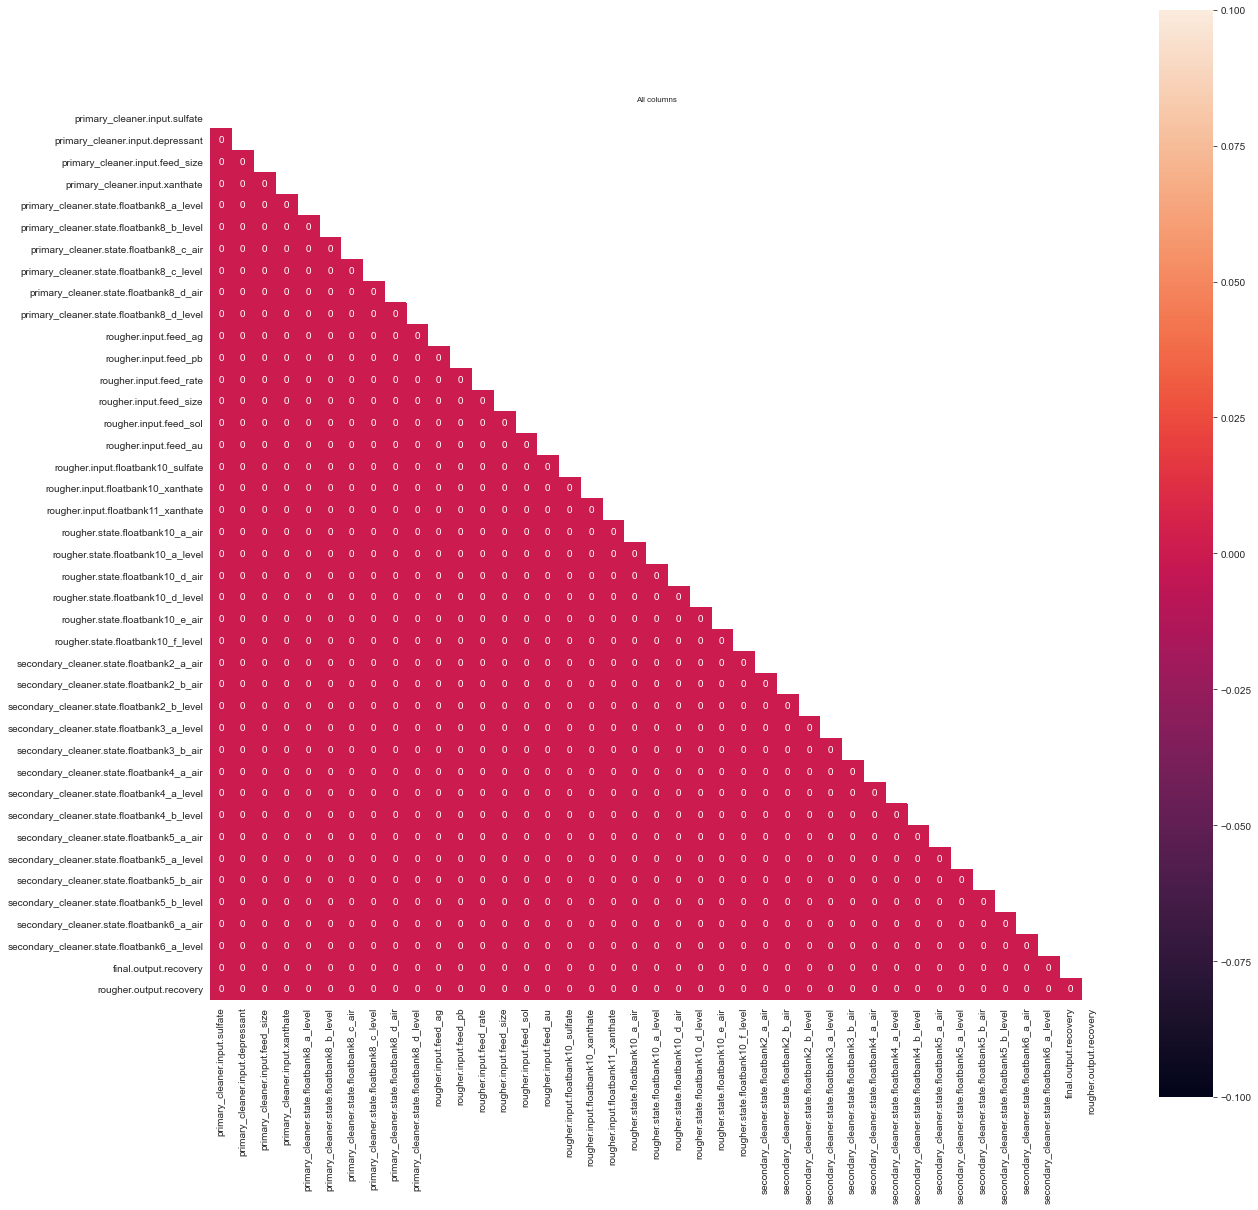

In [101]:
# проверяем что получилось
correlation_heatmap(g_test_upd,corr_level)
# теперь коррелирующие признаки отсутствуют

In [102]:
#изменилась размерность тестовой выборки
print(g_test_upd.shape,g_train.shape)



(5290, 41) (12986, 54)


In [103]:
#в трейне оставляем только те столбцы, что и в тесте
g_train = g_train[g_test_upd.columns]

print(g_test_upd.shape,g_train.shape)

(5290, 41) (12986, 41)


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- устранено, тест = исходному тесту + 2 таргет признака!
    
</div>

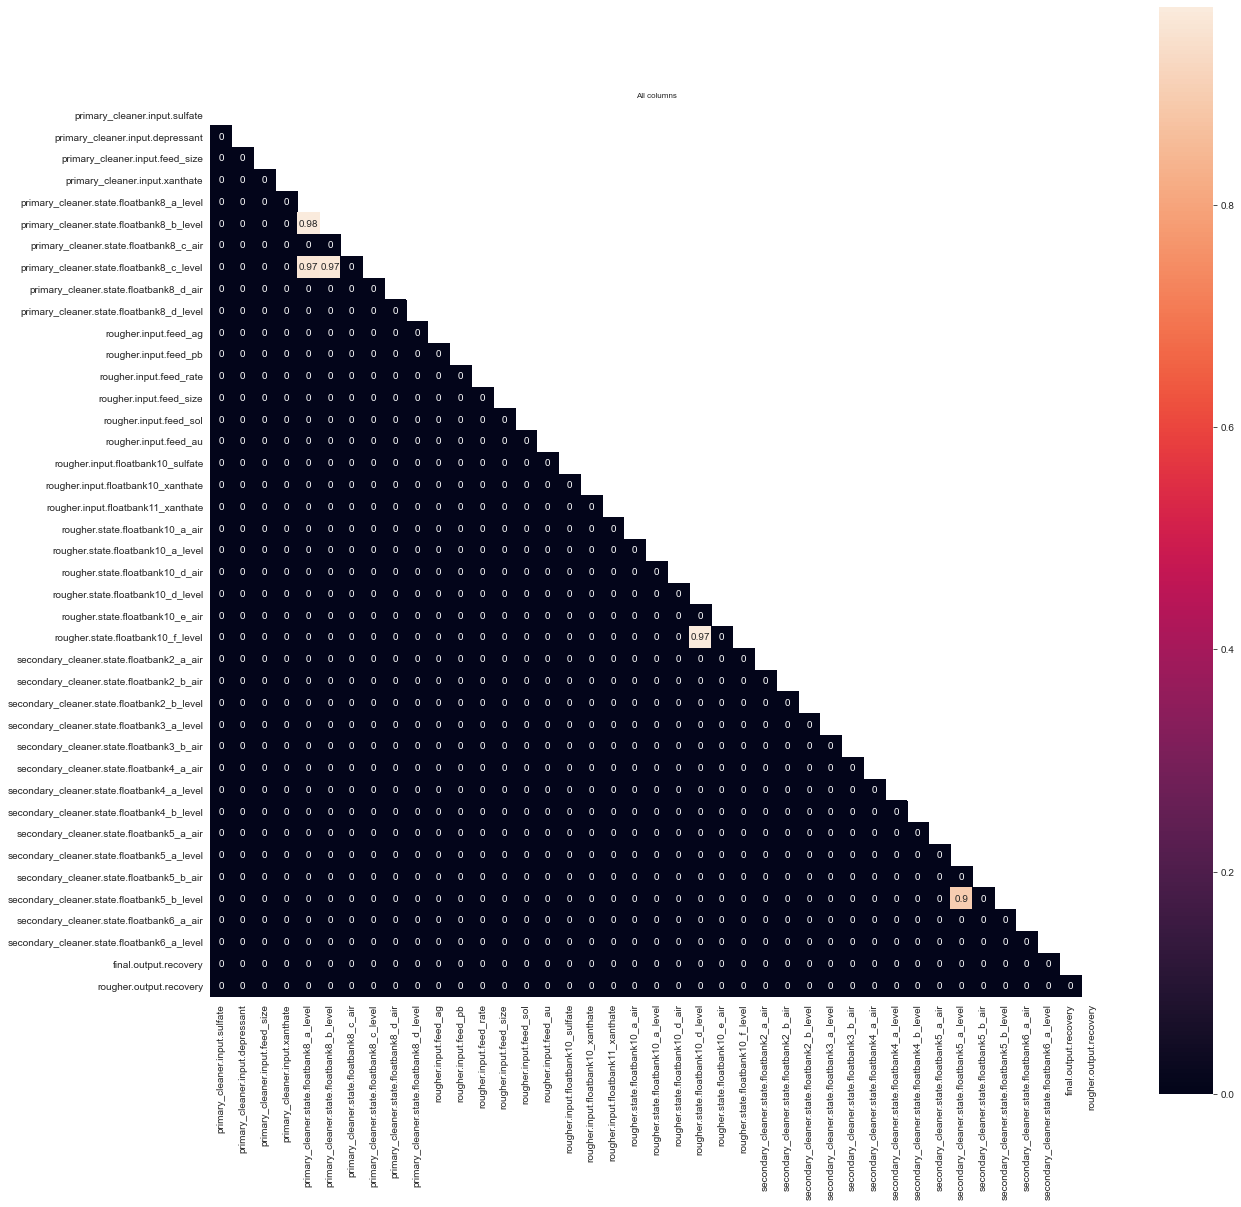

In [104]:
# проверяем на трэйн
correlation_heatmap(g_train,corr_level)
# также часть параметров в трейне еще коррелирует

In [105]:
# удаляем столбцы с мультиколлинеарностью, выводим список удаленных столбцов
g_train, train_drop_cols = multicollinearity(g_train,corr_level)
train_drop_cols
#len(test_drop_cols)

{'primary_cleaner.state.floatbank8_b_level',
 'primary_cleaner.state.floatbank8_c_level',
 'rougher.state.floatbank10_d_level',
 'secondary_cleaner.state.floatbank5_a_level'}

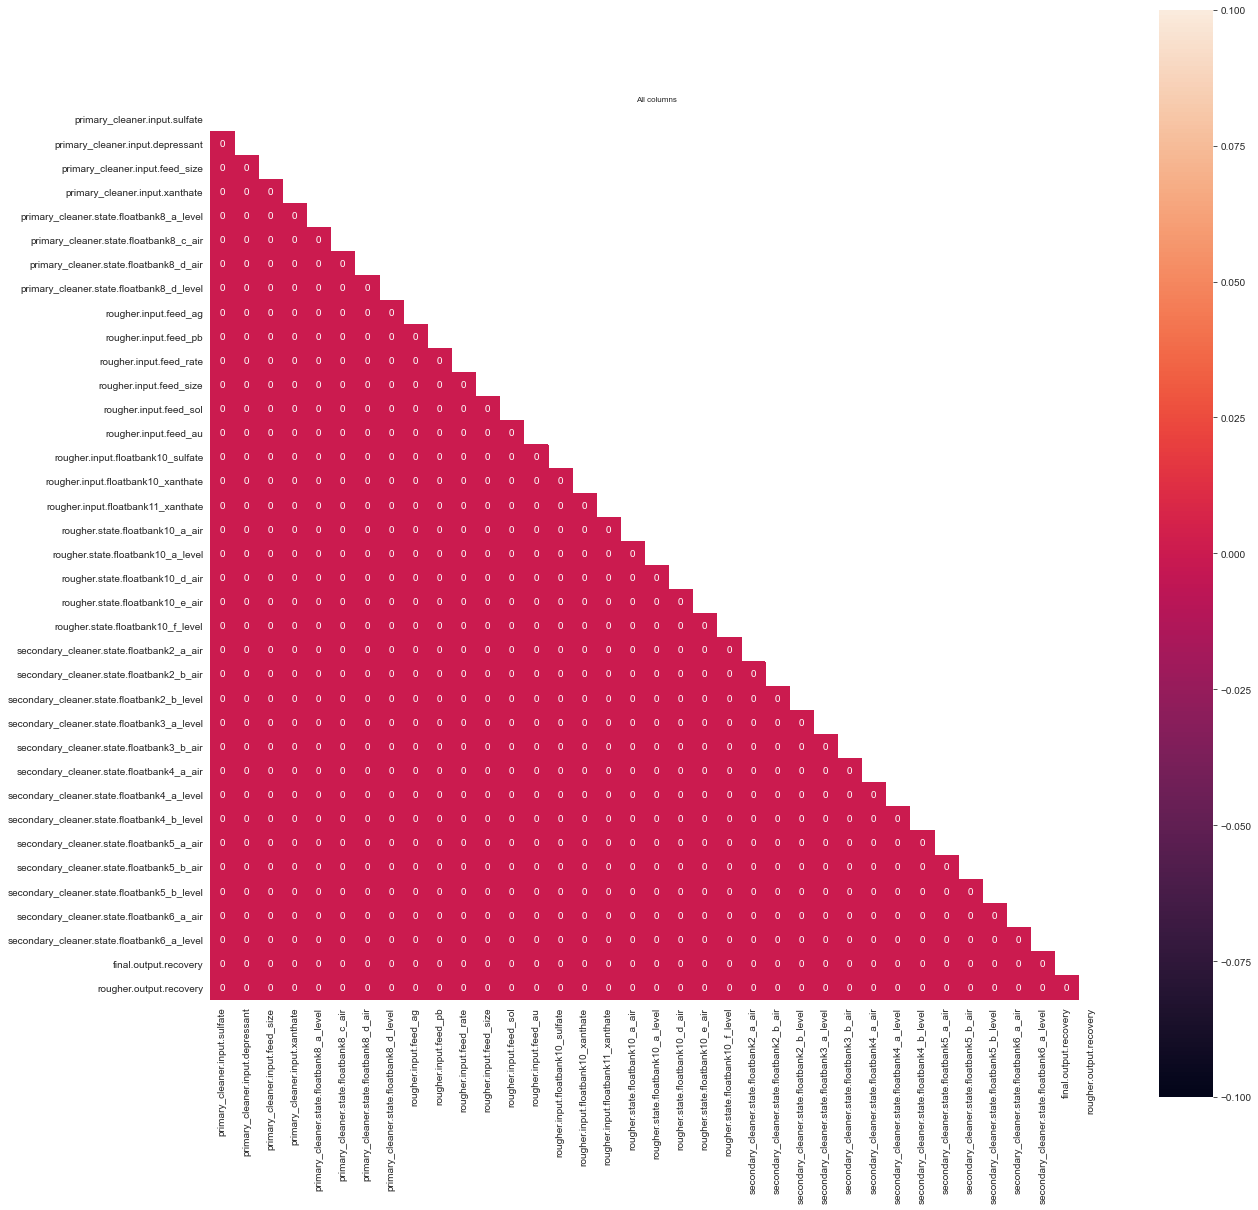

In [106]:
# проверяем что получилось
correlation_heatmap(g_train,corr_level)
# теперь коррелирующие признаки отсутствуют

In [107]:
#в тесте оставляем только те столбцы, что и в трейне
g_test_upd = g_test_upd[g_train.columns]

# количество колонок совпадает
print(g_test_upd.shape,g_train.shape)

(5290, 37) (12986, 37)


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- устранено, тест = исходному тесту + 2 таргет признака!
    
</div>


#### Подитог: UPD
- в тестовой и тренировочной выборках выявлены признаки в которых обнаружена сильная линейная зависимость , т.е. мультиколлинеарность признаков ;
- удалены те признаки в которых дисперсия была выше. Чем выше дисперсия в признаке, тем лучше работает модель. Т.е. **чем у признака больше амплитуда/разброс тем лучше этот признак будет "объяснять" таргет**;

- ~~23 признака;~~ всего удалено 17 признаков;
- список удаленных признаков выведен в test_drop_cols,train_drop_cols. Большинство признаков описывает параметры состояния.


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- применение VIF

Если я правильно нагуглил, то VIF измеряет силу корреляции между каждым признаком и остальными признаками.   
Вычисляется по формуле:

![формула](https://wikimedia.org/api/rest_v1/media/math/render/svg/9ece9d349f82af412b94fcdd2e81c1c6de926936)
    
, где R2 - коэффициент детерминации i-го предиктора относительно остальных
    
Ниже попробовал применить VIF для оставшихся признаков.    
</div>

In [108]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(g_test_upd.values, i) for i in range(g_test_upd.shape[1])]
vif["features"] = g_test_upd.columns

vif.sort_values(by='VIF Factor',ascending=False)



,VIF Factor,features
6,973.216869,primary_cleaner.state.floatbank8_d_air
4,915.735891,primary_cleaner.state.floatbank8_a_level
5,850.618740,primary_cleaner.state.floatbank8_c_air
25,660.154882,secondary_cleaner.state.floatbank3_a_level
20,547.820491,rougher.state.floatbank10_e_air
22,522.321446,secondary_cleaner.state.floatbank2_a_air
23,449.315301,secondary_cleaner.state.floatbank2_b_air
28,419.652372,secondary_cleaner.state.floatbank4_a_level
13,368.864990,rougher.input.feed_au
19,359.287775,rougher.state.floatbank10_d_air


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- цифры какие-то огромные получились, и это при условии , что я уже удалил 17 признаков;
- гугл говорит, что VIF > 5 это повод задуматься, а > 10 надо удалять признак.
- если удалить все признаки > 10 то модель не на чем будет строить, поэтому вероятно дальше работать будут только "деревянные модели"
    
**ВОПРОС:** чтобы ты посоветовал сделать с такой мультиколлинеарностью?    
    
</div>

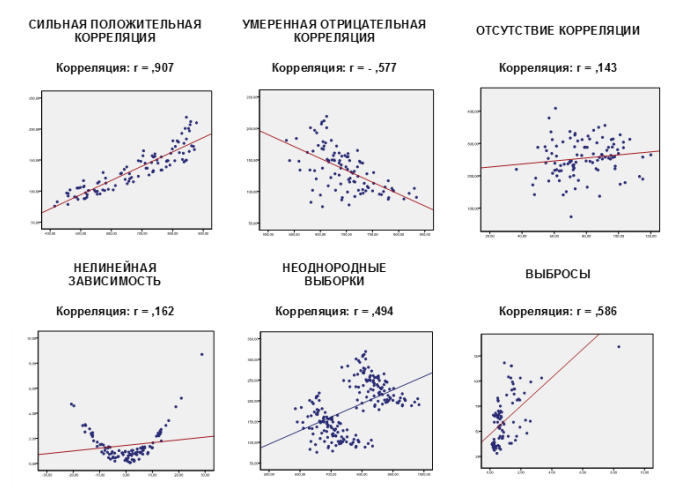

## Напишите функцию для вычисления итоговой sMAPE

**sMAPE** (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).  
Она похожа на MAE, но выражается не в абсолютных величинах, а в относительных. Почему симметричная? Она одинаково учитывает масштаб и целевого признака, и предсказания.
Метрика sMAPE вычисляется так:

![формула](https://pictures.s3.yandex.net/resources/smape_1576238825.jpg)


In [109]:
# функция расчитывает smape для этапа

#def smape_rougher(row):
#    y_true = row['rougher.output.recovery']
#    y_pred = row['rougher.output.recovery.predict']
#    smape_rougher = 100*abs(y_true-y_pred)/((abs(y_true)+abs(y_pred))/2)

#    return smape_rougher

def smape_scorer(y_true,y_pred):
    smape = abs((100*abs(y_true-y_pred)/((abs(y_true)+abs(y_pred))/2)).mean())
    return smape

In [110]:
# функция расчитывает smape_final для каждой строки

#def smape_final(row):
#    y_true = row['final.output.recovery']
#    y_pred = row['final.output.recovery.predict']
#    smape_final = 100*abs(y_true-y_pred)/((abs(y_true)+abs(y_pred))/2)
    
#    return smape_final

![формула](https://pictures.s3.yandex.net/resources/_smape_1576238814.jpg)

In [111]:
#def smape(df):
#    smape_rougher = df['smape_rougher'].sum()/df.shape[0]
    #smape_rougher = smape_rougher/df.shape[0]
#    smape_final = df['smape_final'].sum()/df.shape[0]
    #smape_final = smape_final/df.shape[0]
#    smape = 0.25*smape_rougher + 0.75*smape_final
#    return smape

## Обучите разные модели и оцените их качество кросс-валидацией. Выберите лучшую модель и проверьте её на тестовой выборке. Опишите выводы

In [112]:
# значение для random_state
RNS = 1917

# будем считать данные из g_train как  train 
x_train = g_train.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
y_train = g_train[['final.output.recovery','rougher.output.recovery']]

# будем считать данные из g_test_upd как  test

x_test = g_test_upd.drop(['final.output.recovery','rougher.output.recovery'], axis=1)
y_test = g_test_upd[['final.output.recovery','rougher.output.recovery']]

#display(X.head())
#display(y.head())

In [113]:
x_train.shape, x_test.shape

((12986, 35), (5290, 35))

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>    

- устранено, тест = исходному тесту + 2 таргет признака!
    
</div>

In [114]:
# столбцы понадобятся для моделирования этапа флотации
# train columns lists
final_train,primary_cleaner_train,rougher_train,secondary_cleaner_train,other_stage_train,\
input_train,output_train,state_train,calculation_train,other_params_train =  cols_name(x_train)

# test columns lists
final_test,primary_cleaner_test,rougher_test,secondary_cleaner_test,other_stage_test,\
input_test,output_test,state_test,calculation_test,other_params_test =  cols_name(x_test)

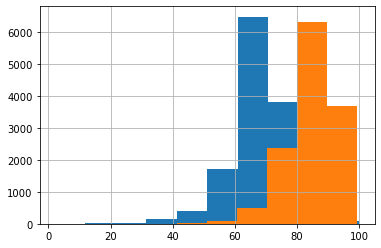

In [115]:
# распределение таргета почти нормальное
y_train['final.output.recovery'].hist()
y_train['rougher.output.recovery'].hist()

In [116]:
# создаем обычную модель линейной регресии, настраиваем и даем предсказания
def LR_model(model,x_train,y_train,x_test):
    model = model
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    return y_pred,model

In [117]:
# Ridge с кросс валидацией

#x_train_columns = x_train.columns

def ridge_cv(x_train,y_train,x_test,y_test,name,columns):
    #r2 = make_scorer(r2_score)
    smape_score = make_scorer(smape_scorer, greater_is_better = False)
    #mae_scorer = make_scorer(mean_absolute_error)
    regr_Ridge = RidgeCV(alphas=np.logspace(-6, 20, 30),scoring = smape_score,cv = 5 )
    regr_Ridge.fit(x_train,y_train)
    predict = regr_Ridge.predict(x_test)
    predict_mean = predict.mean()
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    r_2 = r2_score(y_test, predict)
    mae = mean_absolute_error(y_test, predict)
    smape = smape_scorer(y_test,predict)
    df_coef = pd.DataFrame(data = regr_Ridge.coef_ , index = columns).rename({0:('coef'+'_'+name)},axis = 1)
    df_metrics = pd.DataFrame(data = [rmse,r_2,mae,predict_mean,smape], index = ['RMSE','r_2','MAE','predict_mean','smape']).rename({0:name},axis = 1)
    return df_coef,df_metrics

In [118]:
def scaler(x_train,x_test):
    ss = StandardScaler()
    ss.fit(x_train)
    train = ss.transform(x_train)
    test = ss.transform(x_test)
    return train,test

In [119]:
# расчет метрик регрессии
def metrics(y_true,y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r_2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    smape = smape_scorer(y_true,y_pred)

    return rmse,r_2,mae,smape

In [120]:
# вывод на экран значений метрик
def total_metrics(model,y_true,y_pred,X,name,predict_mean):
    rmse,r_2,mae = metrics(y_true,y_pred)
    df_coef = pd.DataFrame(data = model.coef_, index = X.columns).rename({0:('coef'+'_'+name)},axis = 1)
    #print('Coefficients LinearRegression:\n',model.coef_,'\n')
    #print('Root mean squared error LinearRegression: %.3f'% rmse,'\n')
    #print('Coefficient of determination LinearRegression: %.3f'% r_2,'\n')
    #print('Mean absolute error LinearRegression: %.3f'% mae)
    df_metrics = pd.DataFrame(data = [rmse,r_2,mae,predict_mean], index = ['RMSE','r_2','MAE','predict_mean']).rename({0:name},axis = 1)
    return df_coef,df_metrics

In [121]:
# дерево решений

def decision_tree(x_train,y_train,x_test,y_test,depth,name):
    model = DecisionTreeRegressor(max_depth=depth)
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    predict_mean = predict.mean()
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    r_2 = r2_score(y_test, predict)
    mae = mean_absolute_error(y_test, predict)
    df_feat_importance = pd.DataFrame(data = model.feature_importances_ , index = x_train.columns).rename({0:('feature_importances'+'_'+name)},axis = 1)
    df_metrics = pd.DataFrame(data = [rmse,r_2,mae,predict_mean], index = ['RMSE','r_2','MAE','predict_mean']).rename({0:name},axis = 1)
    return df_feat_importance,df_metrics,predict,model

In [122]:
#случайный лес

def RFR(x_train=None,y_train=None,x_test=None,y_test=None,depth=3,estimators=100,min_leaf=1,min_split=2,name=None):
    
    model = RandomForestRegressor(max_depth=depth,
                                  n_estimators = estimators, 
                                  min_samples_leaf = min_leaf,
                                  min_samples_split = min_split,
                                  random_state=RNS
                                 )
    model.fit(x_train,y_train)
    predict = model.predict(x_test)
    predict_mean = predict.mean()
    rmse = np.sqrt(mean_squared_error(y_test, predict))
    r_2 = r2_score(y_test, predict)
    mae = mean_absolute_error(y_test, predict)
    smape = smape_scorer(y_test,predict) 
    df_feat_importance = pd.DataFrame(data = model.feature_importances_ , index = x_train.columns).rename({0:('feature_importances'+'_'+name)},axis = 1)
    df_metrics = pd.DataFrame(data = [rmse,r_2,mae,predict_mean,smape], index = ['RMSE','r_2','MAE','predict_mean','smape']).rename({0:name},axis = 1)
    return df_feat_importance,df_metrics,model

### Линейная регрессия

In [123]:
x_train_ss, x_test_ss = scaler(x_train,x_test)
x_train_ss_r, x_test_ss_r = scaler(x_train[rougher_train],x_test[rougher_train])

In [124]:
LR_model = LinearRegression().fit(x_train_ss,y_train['final.output.recovery'])
LR_predict = LR_model.predict(x_test_ss)

LR_rmse,LR_r_2,LR_mae,LR_smape = metrics(y_test['final.output.recovery'],LR_predict)
LR_df_f = pd.DataFrame(data = [LR_rmse,LR_r_2,LR_mae,LR_smape], index = ['RMSE','r_2','MAE','smape']).rename({0:'LR_final'},axis = 1)
LR_df_f

,LR_final
RMSE,9.418814
r_2,0.019698
MAE,5.882648
smape,9.518438


In [125]:
LR_model_r = LinearRegression().fit(x_train_ss_r,y_train['rougher.output.recovery'])
LR_predict_r = LR_model_r.predict(x_test_ss_r)

LR_rmse_r,LR_r_2_r,LR_mae_r,LR_smape_r = metrics(y_test['rougher.output.recovery'],LR_predict_r)
LR_df_r = pd.DataFrame(data = [LR_rmse_r,LR_r_2_r,LR_mae_r,LR_smape_r], index = ['RMSE','r_2','MAE','smape']).rename({0:'LR_rougher'},axis = 1)
LR_df_r

,LR_rougher
RMSE,12.645393
r_2,0.064837
MAE,5.318922
smape,8.248482


In [126]:
LR_df = LR_df_f.join(LR_df_r)
LR_df['total'] = 0
LR_df.loc['smape','total'] = LR_df.loc['smape','LR_final']*0.75 + LR_df.loc['smape','LR_rougher']*0.25
LR_df

,LR_final,LR_rougher,total
RMSE,9.418814,12.645393,0.000000
r_2,0.019698,0.064837,0.000000
MAE,5.882648,5.318922,0.000000
smape,9.518438,8.248482,9.200949


In [127]:
print('SMAPE для линейной регрессии =' ,LR_df.loc['smape','total'])

SMAPE для линейной регрессии = 9.200949372030117


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
    
- изменил scoring на smape;  
- оформил результаты в виде dataframe    
    
</div>

### Ridge регрессия

In [128]:
ridge_coef,ridge_metrics = ridge_cv(x_train_ss,y_train['final.output.recovery'],
                                    x_test_ss,y_test['final.output.recovery'],'ridge_final',x_train.columns)

In [129]:
ridge_coef_rougher,ridge_metrics_rougher = ridge_cv(x_train_ss_r,y_train['rougher.output.recovery'],
                                    x_test_ss_r,y_test['rougher.output.recovery'],'ridge_rougher',rougher_train)

In [130]:
def metrics_df(df1,df2):
    df = df1.join(df2)
    df['total'] = 0
    df.loc['smape','total'] = df.loc['smape',df.columns[0]]*0.75+df.loc['smape',df.columns[1]]*0.25
    return df



In [131]:
ridge_df = metrics_df(ridge_metrics,ridge_metrics_rougher)
ridge_df

,ridge_final,ridge_rougher,total
RMSE,9.015931,12.594844,0.00000
r_2,0.101767,0.072299,0.00000
MAE,5.417990,5.076840,0.00000
predict_mean,68.808710,85.583042,0.00000
smape,8.882542,7.953374,8.65025


In [132]:
print('SMAPE для ridge регрессии =' ,ridge_df.loc['smape','total'])

SMAPE для ridge регрессии = 8.650250259406302


In [133]:
ridge_coef.sort_values(by='coef_ridge_final',ascending=False).join(ridge_coef_rougher).head(20)

,coef_ridge_final,coef_ridge_rougher
rougher.input.feed_au,1.015301,0.652525
rougher.input.floatbank10_xanthate,0.999663,0.887494
primary_cleaner.input.sulfate,0.826876,NaN
rougher.input.feed_ag,0.759973,0.958380
rougher.input.feed_sol,0.652887,1.045009
secondary_cleaner.state.floatbank2_a_air,0.520638,NaN
rougher.input.floatbank11_xanthate,0.466983,0.237879
secondary_cleaner.state.floatbank4_a_air,0.442802,NaN
primary_cleaner.input.xanthate,0.418036,NaN
primary_cleaner.input.feed_size,0.404599,NaN


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
    
- наиболее значимым оказался признак содержание золота перед флотацией, что логично  
    
</div>

### Random Forest

In [134]:
#y_train
#y_test

In [135]:
#model = RandomForestRegressor(random_state=RNS)
#model.fit(x_train,y_train)
#predict = model.predict(x_train)
#mae = mean_absolute_error(y_train, predict)
#mae#

In [136]:
#mae = mean_absolute_error(y_train, predict)
#mae

In [137]:
# функция выполняет поиск гиперпарметров
# scoring по r2

def RFR_random_search_cv(est_min,est_max,est_num,depth_min,depth_max,depth_num,\
                         split_min,split_max,split_num,leaf_min,leaf_max,leaf_num, cv,n_iter,
                        x_train,y_train):
    #r2 = make_scorer(r2_score)
    smape_score = make_scorer(smape_scorer, greater_is_better = False)
    n_estimators = [int(x) for x in np.linspace(start = est_min, stop = est_max, num = est_num)]
    max_depth = [int(x) for x in np.linspace(start = depth_min, stop = depth_max, num = depth_num)]
    min_samples_split = [int(x) for x in np.linspace(start = split_min, stop = split_max, num = split_num)]
    min_samples_leaf = [int(x) for x in np.linspace(start = leaf_min, stop = leaf_max, num = leaf_num)]
    #bootstrap = [True, False]
    param_dist = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               #'bootstrap': bootstrap
                 }
    
    rs_RFC = RandomizedSearchCV(RandomForestRegressor(random_state=RNS), 
                        param_dist, 
                        n_iter = n_iter, 
                        cv = cv, 
                        verbose = 2,
                        return_train_score=True,
                        n_jobs=-1,
                        scoring = smape_score,
                        random_state=RNS)
    rs_RFC.fit(x_train,y_train)
    rs_RFC_df = pd.DataFrame(rs_RFC.cv_results_).sort_values('rank_test_score').reset_index(drop=True)
    return rs_RFC_df

In [138]:
# функция выполняет финальную настройку гиперпарметров
# scoring по r2

def RFR_grid_search_cv(est,depth,split,leaf,cv,x_train,y_train):
    #r2 = make_scorer(r2_score)
    smape_score = make_scorer(smape_scorer, greater_is_better = False)
    n_estimators = est
    max_depth = depth # [12,14]
    min_samples_split = split
    min_samples_leaf = leaf

    param_grid = {'n_estimators': n_estimators,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                  'min_samples_leaf' : min_samples_leaf,
                }

    gs_RFC = GridSearchCV(RandomForestRegressor(random_state=RNS),
                          param_grid, 
                          cv = cv, 
                          verbose = 2,
                          return_train_score=True, 
                          n_jobs=-1,
                          scoring = smape_score,

                         )
    gs_RFC.fit(x_train,y_train)
    gs_RFC.best_estimator_
    gs_RFC.best_params_
    return gs_RFC.best_params_



In [139]:
'''RFR_random_search_cv(est_min = 20,
                     est_max = 200,
                     est_num = 5,
                    depth_min = 5,
                     depth_max = 25,
                     depth_num = 7,
                     split_min = 2,
                     split_max = 12,
                     split_num = 3,
                     leaf_min = 2,
                     leaf_max = 8,
                     leaf_num = 3, 
                     cv = 5,
                     n_iter = 20,
                     x_train = x_train,
                     y_train = y_train['final.output.recovery'])'''

"RFR_random_search_cv(est_min = 20,\n                     est_max = 200,\n                     est_num = 5,\n                    depth_min = 5,\n                     depth_max = 25,\n                     depth_num = 7,\n                     split_min = 2,\n                     split_max = 12,\n                     split_num = 3,\n                     leaf_min = 2,\n                     leaf_max = 8,\n                     leaf_num = 3, \n                     cv = 5,\n                     n_iter = 20,\n                     x_train = x_train,\n                     y_train = y_train['final.output.recovery'])"

In [140]:
'''RFR_random_search_cv(est_min = 20,
                     est_max = 200,
                     est_num = 5,
                     depth_min = 5,
                     depth_max = 25,
                     depth_num = 7,
                     split_min = 2,
                     split_max = 12,
                     split_num = 3,
                     leaf_min = 2,
                     leaf_max = 8,
                     leaf_num = 3, 
                     cv = 5,
                     n_iter = 20,
                     x_train = x_train[rougher_train],
                     y_train = y_train['rougher.output.recovery'])'''

"RFR_random_search_cv(est_min = 20,\n                     est_max = 200,\n                     est_num = 5,\n                     depth_min = 5,\n                     depth_max = 25,\n                     depth_num = 7,\n                     split_min = 2,\n                     split_max = 12,\n                     split_num = 3,\n                     leaf_min = 2,\n                     leaf_max = 8,\n                     leaf_num = 3, \n                     cv = 5,\n                     n_iter = 20,\n                     x_train = x_train[rougher_train],\n                     y_train = y_train['rougher.output.recovery'])"

In [141]:
#RFR_grid_search_cv(est = [75,82],
#                   depth = [25,30],
#                   split = [10,12],
#                   leaf = [2],
#                   cv = 5 ,
#                   x_train = x_train,
#                   y_train = y_train['final.output.recovery'])

In [142]:
#RFR_grid_search_cv(est = [100,110],
#                   depth = [10,12],
#                   split = [12,15],
#                   leaf = [8,10],
#                   cv = 5 ,
#                   x_train = x_train[rougher_train],
#                   y_train = y_train['rougher.output.recovery'])

In [143]:
RFR_feature_final,RFR_metrics_final,model_RFR_final = RFR(
    x_train=x_train,
    y_train=y_train['final.output.recovery'],
    x_test=x_test,
    y_test=y_test['final.output.recovery'],
    name='RFR_final')

RFR_metrics_final

,RFR_final
RMSE,9.267775
r_2,0.050886
MAE,5.799446
predict_mean,68.008831
smape,9.476703


In [144]:
RFR_feature_rougher,RFR_metrics_rougher,model_RFR_rougher = RFR(
    x_train=x_train[rougher_train],
    y_train=y_train['rougher.output.recovery'],
    x_test=x_test[rougher_train],
    y_test=y_test['rougher.output.recovery'],
    name='RFR_rougher')
RFR_metrics_rougher

,RFR_rougher
RMSE,13.027781
r_2,0.007425
MAE,5.773775
predict_mean,85.315768
smape,8.769320


In [145]:
RFR_default_df = RFR_metrics_final.join(RFR_metrics_rougher)
RFR_default_df['total'] = 0
RFR_default_df.loc['smape','total'] = RFR_default_df.loc['smape','RFR_final']*0.75+RFR_default_df.loc['smape','RFR_rougher']*0.25

RFR_default_df

,RFR_final,RFR_rougher,total
RMSE,9.267775,13.027781,0.000000
r_2,0.050886,0.007425,0.000000
MAE,5.799446,5.773775,0.000000
predict_mean,68.008831,85.315768,0.000000
smape,9.476703,8.769320,9.299857


In [146]:
print('SMAPE для Random Forest без настройки =' ,RFR_default_df.loc['smape','total'])

SMAPE для Random Forest без настройки = 9.299857315003077


In [147]:
RFR_feature_final_tune,RFR_metrics_final_tune,model_RFR_final_tune = RFR(
    x_train=x_train,
    y_train=y_train['final.output.recovery'],
    x_test=x_test,
    y_test=y_test['final.output.recovery'],
    depth=11,
    estimators=200,
    min_leaf=7,
    min_split=2,
    name='RFR_tune_final')

RFR_metrics_final_tune

,RFR_tune_final
RMSE,9.095838
r_2,0.085775
MAE,5.682811
predict_mean,67.425812
smape,9.334393


In [148]:
RFR_feature_rougher_tune,RFR_metrics_rougher_tune,model_RFR_rougher_tune = RFR(
    x_train=x_train[rougher_train],
    y_train=y_train['rougher.output.recovery'],
    x_test=x_test[rougher_train],
    y_test=y_test['rougher.output.recovery'],
    depth=18,
    estimators=155,
    min_leaf=8,
    min_split=2,
    name='RFR_tune_rougher')

RFR_metrics_rougher_tune

,RFR_tune_rougher
RMSE,12.814876
r_2,0.039602
MAE,5.447700
predict_mean,86.235639
smape,8.354439


In [149]:
RFR_tune_df = RFR_metrics_final_tune.join(RFR_metrics_rougher_tune)
RFR_tune_df['total'] = 0
RFR_tune_df.loc['smape','total'] = RFR_tune_df.loc['smape','RFR_tune_final']*0.75+RFR_tune_df.loc['smape','RFR_tune_rougher']*0.25

RFR_tune_df

,RFR_tune_final,RFR_tune_rougher,total
RMSE,9.095838,12.814876,0.000000
r_2,0.085775,0.039602,0.000000
MAE,5.682811,5.447700,0.000000
predict_mean,67.425812,86.235639,0.000000
smape,9.334393,8.354439,9.089405


In [150]:
print('SMAPE для Random Forest после настройки =' ,RFR_tune_df.loc['smape','total'])

SMAPE для Random Forest после настройки = 9.089404795019554


In [151]:
RFR_feature_final_tune.sort_values(by='feature_importances_RFR_tune_final',ascending=False).join(RFR_feature_rougher_tune).head(20)

,feature_importances_RFR_tune_final,feature_importances_RFR_tune_rougher
rougher.input.feed_ag,0.215728,0.136854
primary_cleaner.input.sulfate,0.135550,NaN
secondary_cleaner.state.floatbank2_a_air,0.069242,NaN
rougher.input.floatbank10_xanthate,0.065363,0.050483
rougher.input.feed_size,0.049409,0.073342
rougher.input.floatbank10_sulfate,0.031253,0.029198
rougher.input.feed_au,0.031056,0.044098
primary_cleaner.state.floatbank8_c_air,0.029413,NaN
rougher.input.floatbank11_xanthate,0.028477,0.050518
rougher.state.floatbank10_e_air,0.026389,0.067442


In [152]:
#RFR_metrics= RFR_metrics_final.join([RFR_metrics_final_tune,RFR_metrics_rougher,RFR_metrics_rougher_tune])
#RFR_metrics

In [153]:
#RFR_feature_rougher_tune.sort_values(by='feature_importances_RFR_tune_rougher',ascending=False).head()

In [154]:
#RFR_feature_final_tune.sort_values(by='feature_importances_RFR_tune_final',ascending=False).head()

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
    
- в этот раз перебор параметров с кросс-валидацией не дал существенного прироста, как в случае когда признаков было 80+;    
- наиболее значимым оказался признак содержание серебра перед флотацией, что не совсем логично;
- в коэффициентах  для флотации отсутсвует часть признаков, т.к. для расчета флотации использовались только  признаки этапа флотации! 
    
    
</div>

### Подитог UPD:
- ~~в процессе настройки отлично сработала кросс-валидация с подбором параметров для случайного леса;~~
- в процессе настройки отлично сработала кросс-валидация с подбором парамертра регуляризации для ridge регрессии;
-~~лучшие метрики у случайного леса, его данные и будем использовать для расчета SMAPE;~~
- лучшие метрики у ridge регрессии;
- ключевым параметром для целевых признаков стало ~~наличие золота в хвостах на этапах флотации/готового продукта~~ наличие золота в гранулах на перед этапом флотации;
- при моделировании для этапа флотации использовались только параметры этого этапа, т.к. остальные признаки относятся к след.этапам и никак не влияют на этот параметр;
- ~~метрика MAE в пределах 2% от среднего; ~~

## ~~Расчет SMAPE~~

In [155]:
#g_test_upd['rougher.output.recovery.predict'] = model_RFR_rougher_tune.predict(x_test[rougher_train])
#g_test_upd['final.output.recovery.predict'] = model_RFR_final_tune.predict(x_test)

In [156]:
#g_test_upd['smape_rougher'] = g_test_upd.apply(smape_rougher,axis = 1)
#g_test_upd['smape_final'] = g_test_upd.apply(smape_rougher,axis = 1)


In [157]:
print('Cимметричное среднее абсолютное процентное отклонение для лучшей модели = ',ridge_df.loc['smape','total'])

Cимметричное среднее абсолютное процентное отклонение для лучшей модели =  8.650250259406302


In [158]:
y_pred_dummy = np.array([g_test_upd['final.output.recovery'].median() for i in g_test_upd['final.output.recovery']])
y_pred_dummy_r = np.array([g_test_upd['rougher.output.recovery'].median() for i in g_test_upd['rougher.output.recovery']])
print(y_pred_dummy.shape[0],y_pred_dummy_r.shape[0])

5290 5290


In [159]:
rmse,r_2,mae,smape = metrics(g_test_upd['final.output.recovery'],y_pred_dummy)
rmse_r,r_2_r,mae_r,smape_r = metrics(g_test_upd['rougher.output.recovery'],y_pred_dummy_r)
dummy_smape = smape*0.75 + smape_r*0.25
print('Cимметричное среднее абсолютное процентное отклонение для Dummy модели =',dummy_smape)

Cимметричное среднее абсолютное процентное отклонение для Dummy модели = 8.889496773146027


<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b>
    
- спасибо за развернутое аргументированное ревью;
- надеюсь еще увидимся в будущих проектах!
    
</div>

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке